## Constants and dataloading

In [1]:
import json
import smart_open
import pandas as pd
import os
from tqdm import tqdm
import matplotlib

## file path constants

In [2]:
FIGURE_DIR = "/Users/ianm/projects/ppl-suite-paper-runs/figures"
TABLES_DIR = "/Users/ianm/projects/ppl-suite-paper-runs/tables"
RESULTS_DIR = "/Users/ianm/projects/ppl-suite-paper-runs/results"
TOKEN_COUNTS_DIR = "/Users/ianm/projects/ppl-suite-paper-runs/token_counts"

model_name_to_path = {
    'dolma-1b': 'olmo/1b/olmo-small-dolma-150B-mcli-results-eos-fix/',
    'pile-1b': 'olmo/1b/olmo-small--pile-lumi-150B-mcli-results-eos-fix/',
    'falcon-1b': 'olmo/1b/olmo-small-falcon-150B-mcli-results-really-really-fixed-eos-full/',
    'c4-1b': 'olmo/1b/olmo-small-c4-lumi-150B-mcli-results-eos-fix/',
    'mc4-1b': 'olmo/1b/olmo-small-mc4-lumi-150B-mcli-results-eos-fix/',
    'rpj-1b': 'olmo/1b/olmo-small-rpj-lumi-150B-mcli-results-eos-fix/',
    # 'dolma-7b': 'olmo/7b/v1_5-mix-mitch-ish-1_5T_tokens',
    'pythia-160m': 'pythia/160m-seed1/',
    # 'pythia-160m-seed2': 'pythia/160m-seed2/',
    'pythia-1b': 'pythia/1b',
    'pythia-6.9b': 'pythia/7b',
    # 'rp-incite-7b': 'redpajama-incite/7b',
    
}

## visualization

In [3]:
# configurations
metric_name = 'ppl_token'
model_dataset_names_to_marker = {
    'Dolma V1.5 olmo 1B': '*',
    'RedPajama olmo 1B': 'P',
    'The Pile olmo 1B': 'X',
    'c4 olmo 1B': 'p',
    'mc4 olmo 1B': 'h',
    'Falcon-RefinedWeb olmo 1B': '8',
    '1-Pythia 7B/Pythia 1B': 's',
    '1-Pythia 1B/Pythia 160M': 'D',
 }

model_dataset_names_to_linestyle = {
    'Dolma V1.5 olmo 1B': 'dotted',
    'RedPajama olmo 1B': 'dashed',
    'The Pile olmo 1B': 'dashdot',
    'c4 olmo 1B': (0, (1, 1)),
    'mc4 olmo 1B': (0, (5, 1)),
    'Falcon-RefinedWeb olmo 1B': (0, (3, 5, 1, 5, 1, 5)),
    '1-Pythia 7B/Pythia 1B': 'dotted',
    '1-Pythia 1B/Pythia 160M': 'dashed',
}

model_name_to_model_dataset_names = {
    'dolma-1b': 'Dolma V1.5 olmo 1B',
    'rpj-1b': 'RedPajama olmo 1B',
    'pile-1b': 'The Pile olmo 1B',
    'c4-1b': 'c4 olmo 1B',
    'mc4-1b': 'mc4 olmo 1B',
    'falcon-1b': 'Falcon-RefinedWeb olmo 1B',
    '1-Pythia 1B/Pythia 160M': '1-Pythia 1B/Pythia 160M',
    '1-Pythia 7B/Pythia 1B': '1-Pythia 7B/Pythia 1B',
}

model_name_to_marker = { k: model_dataset_names_to_marker[v] for k, v in model_name_to_model_dataset_names.items() }
model_name_to_linestyle = { k: model_dataset_names_to_linestyle[v] for k, v in model_name_to_model_dataset_names.items() }
model_name_to_color = {k: matplotlib.cm.Dark2(i) for i, k in enumerate(model_name_to_model_dataset_names.keys())}
model_dataset_names_to_color = {k: matplotlib.cm.Dark2(i) for i, k in enumerate(model_dataset_names_to_marker.keys())}

In [4]:
# number normalization
def display_size(size, use_non_embedding_params=False):
    if size == 85056000: # pythia 160m
        return "160M"
    elif size == 805736448: # pythia 1b
        return "1B"
    elif size == 1177240704: # dolma 1b and our baselines
        return "1B"
    elif size == 6444163072: # pythia 6.9b
        return "7B"
    elif size == 6855589888: # rp-incite 7b
        return "7B"
    elif use_non_embedding_params:
        if size < 1000000000:
            return f"{math.ceil(size/1000000)}M"
        else:
            return f"{math.ceil(size/1000000000)}B"
    else:
        raise ValueError(f"Unknown size: {size}")

def human_readable_int(num, precision=0):
    if num < 1000:
        return f"{num:.{precision}f}"
    elif num < 1000000:
        return f"{num/1000:.{precision}f}K"
    elif num < 1000000000:
        return f"{num/1000000:.{precision}f}M"
    else:
        return f"{num/1000000000:.{precision}f}B"

In [5]:
# display names
name_to_display = {
    'ppl_c4_en': 'C4',
    'ppl_falcon-refinedweb': 'Falcon',
    'ppl_mc4': 'MC4',
    'ppl_ptb': 'PTB',
    'ppl_wikitext_103': 'WikiText-103',
    'ppl_redpajama': 'RedPajama',
    'ppl_dolma-v1_5': 'Dolma V1.5',
    'ppl_pile': 'The Pile',
    'ppl_c4_100_domains': 'C4 100 Domains',
    'ppl_dolma_100_programing_languages': '100 PLs',
    'ppl_dolma_100_subreddits': '100 Subreddits',
    'ppl_ice_fixed': 'ICE',
    'ppl_m2d2_s2orc_unsplit': 'M2D2 S2ORC',
    'ppl_m2d2_wikipedia_unsplit': 'M2D2 Wikipedia',
    'ppl_manosphere_meta_sep': 'Manosphere',
    'ppl_twitterAAE_HELM_fixed': 'Twitter AAE',
    'ppl_4chan_meta_sep': '4chan',
    'ppl_gab': 'Gab',
    'model': 'Model',
    'model_size': 'Model Size',
    'split': 'Split',
    'tokens_seen': 'Tokens Seen',
    'training_dataset': 'Training Dataset',
    'training_steps': 'Training Steps',
    'bits_per_byte': 'Bits Per Byte',
    'ppl_token': 'Perplexity per Token',
    'All': 'All',
    'EAST_AFRICA_W_ALL': 'East Africa Written',
    'PHILIPPINES_S_ALL': 'Philippines Spoken',
    'PHILIPPINES_W_ALL': 'Philippines Written',
    'HONG_KONG_S_ALL': 'Hong Kong Spoken',
    'SINGAPORE_W_ALL': 'Singapore Written',
    'IRELAND_W_ALL': 'Ireland Written',
    'JAMAICA_S_ALL': 'Jamaica Spoken',
    'INDIA_S_ALL': 'India Spoken',
    'EAST_AFRICA_S_ALL': 'East Africa Spoken',
    'CANADA_S_ALL': 'Canada Spoken',
    'SINGAPORE_S_ALL': 'Singapore Spoken',
    'JAMAICA_W_ALL': 'Jamaica Written',
    'IRELAND_S_ALL': 'Ireland Spoken',
    'CANADA_W_ALL': 'Canada Written',
    'USA_W_ALL': 'USA Written',
    'INDIA_W_ALL': 'India Written',
    'HONG_KONG_W_ALL': 'Hong Kong Written',
    'AA': 'AA',
    'white': 'White',
    'pythia-6.9b': 'Pythia 7B',
    'pythia-1b': 'Pythia 1B',
    'pythia-160m': 'Pythia 160M',
    'pythia-160m-seed2': 'Pythia 160M Seed 2',
    'dolma-1b': 'Dolma v1.5 1B',
    'dolma-7b': 'Dolma 7B',
    'falcon-1b': 'Falcon-RefinedWeb 1B',
    'rpj-1b': 'RedPajama 1B',
    'rp-incite-7b': 'RedPajama 7B',
    'pile-1b': 'The Pile 1B',
    'c4-1b': 'C4 1B',
    'mc4-1b': 'MC4 1B',
    '1-Pythia 7B/Pythia 1B': '1 - (Pythia 7B / Pythia 1B)',
    '1-Pythia 1B/Pythia 160M': '1 - (Pythia 1B / Pythia 160m)'
}

name_to_macro = {
    'wikitext_103': '\\wikitext',
    'twitterAAE_HELM_fixed': '\\twitterAAE',
    'redpajama': '\\redPajama',
    'ptb': '\\ptb',
    'pile': '\\pile',
    'mc4': '\\mCFourEn',
    'manosphere_meta_sep': '\\manosphere',
    'm2d2_wikipedia_unsplit': '\\mTwoDTwoWiki',
    'm2d2_s2orc_unsplit': '\\mTwoDTwoSTwoORC',
    'ice_fixed': '\\ice',
    'gab': '\\gab',
    'falcon-refinedweb': '\\falcon',
    'dolma_100_subreddits': '\\dolmaOneHundredSubreddits',
    'dolma_100_programing_languages': '\\stackOneHundredLanguages',
    'dolma-v1_5': '\\dolma',
    'c4_en': '\\cFour',
    'c4_100_domains': '\\cFourOneHundredDomains',
    '4chan_meta_sep': '\\fourChan',
}

domain_order = [
    'c4_en',
    'mc4',
    'pile',
    'wikitext_103',
    'ptb',
    'redpajama',
    'falcon-refinedweb',
    'dolma-v1_5',
    
    'm2d2_s2orc_unsplit',
    'm2d2_wikipedia_unsplit',
    'c4_100_domains',
    'dolma_100_subreddits',
    'dolma_100_programing_languages',
    
    'ice_fixed',
    'twitterAAE_HELM_fixed',
    
    'manosphere_meta_sep',
    'gab',
    '4chan_meta_sep',
]

## Name sets

In [6]:
trained_baseline_models = {'dolma-1b', 'falcon-1b', 'c4-1b', 'mc4-1b', 'pile-1b', 'rpj-1b'}

shared_cols = {
    'model',
    'model_size',
    'split',
    'tokens_seen',
    'training_dataset',
    'training_steps'
 }

non_domain_cols = {
    "date",
    "model",
    "model_kwargs",
    "full_model",
    "task",
    "processing_time",
    "num_instances",
    "tango_workspace",
    "tango_step",
    "model_max_length",
    "max_batch_tokens",
    "batch_size",
    "limit",
    "split",
    "random_subsample_seed",
    "model_size",
    "training_steps",
    "tokens_seen",
    "training_dataset"
}

all_standard_tasks = ['ppl_falcon-refinedweb',
 'ppl_wikitext_103',
 'ppl_ptb',
 'ppl_c4_en',
 'ppl_mc4',
 'ppl_dolma-v1_5',
 'ppl_pile',
 'ppl_redpajama']

fringe_domains = {
    'ppl_manosphere_meta_sep',
    'ppl_4chan_meta_sep',
    'ppl_gab'
}

standard_lm_benchmarks = {
    'ppl_c4_en',
    'ppl_falcon-refinedweb',
    'ppl_mc4',
    'ppl_ptb',
    'ppl_wikitext_103'
}

domains_with_subdomains = {
    'ppl_c4_100_domains',
    'ppl_dolma-v1_5',
    'ppl_dolma_100_programing_languages',
    'ppl_dolma_100_subreddits',
    'ppl_ice_fixed',
    'ppl_m2d2_s2orc_unsplit',
    'ppl_m2d2_wikipedia_unsplit',
    'ppl_manosphere_meta_sep',
    'ppl_pile',
    'ppl_redpajama',
    'ppl_twitterAAE_HELM_fixed'
}

domains_without_subdomains = {
    'ppl_4chan_meta_sep',
    'ppl_c4_en',
    'ppl_falcon-refinedweb',
    'ppl_gab',
    'ppl_mc4',
    'ppl_ptb',
    'ppl_wikitext_103'
}

domains_without_subdomains_clean = set(d for d in domains_without_subdomains if all(fringe_domain not in d for fringe_domain in fringe_domains))
domains_with_subdomains_clean = set(domains_with_subdomains) - fringe_domains
all_domains = domains_with_subdomains | domains_without_subdomains
all_domains_clean = list(domains_with_subdomains_clean - {'ppl_dolma_100_programing_languages'}) + list(domains_without_subdomains_clean)

results_files_all = os.listdir(os.path.join(RESULTS_DIR, model_name_to_path['dolma-1b']))
results_files_clean = [f for f in results_files_all if all(fringe_domain not in f for fringe_domain in fringe_domains)]

In [7]:
# map tasks to domains

task_to_domains = {
'ppl_twitterAAE_HELM_fixed': {'AA', 'white'},
 'ppl_manosphere_meta_sep': {'avfm',
  'incels',
  'love_shy',
  'mgtow',
  'pua_forum',
  'red_pill_talk',
  'reddit',
  'rooshv',
  'the_attraction'},
 'ppl_c4_100_domains': {'100_www.ign.com',
  '10_www.eventbrite.com',
  '11_link.springer.com',
  '12_www.chicagotribune.com',
  '13_www.foxnews.com',
  '14_www.aljazeera.com',
  '15_www.dailymail.co.uk',
  '16_www.ncbi.nlm.nih.gov',
  '17_www.express.co.uk',
  '18_en.m.wikipedia.org',
  '19_www.cnet.com',
  '1_www.nytimes.com',
  '20_www.telegraph.co.uk',
  '21_www.theatlantic.com',
  '22_forums.macrumors.com',
  '23_www.oreilly.com',
  '24_www.washingtonpost.com',
  '25_www.zdnet.com',
  '26_www.foxbusiness.com',
  '27_www.reuters.com',
  '28_www.ibtimes.co.uk',
  '29_www.rt.com',
  '2_en.wikipedia.org',
  '30_www.prweb.com',
  '31_www.deviantart.com',
  '32_www.si.com',
  '33_www.bbc.com',
  '34_github.com',
  '35_nypost.com',
  '36_itunes.apple.com',
  '37_www.instructables.com',
  '38_www.youtube.com',
  '39_www.booking.com',
  '40_www.etsy.com',
  '41_www.marketwired.com',
  '42_sites.google.com',
  '43_www.baltimoresun.com',
  '44_www.agreatertown.com',
  '45_www.npr.org',
  '46_www.fool.com',
  '47_www.tripadvisor.com',
  '48_www.bbc.co.uk',
  '49_lists.w3.org',
  '4_www.latimes.com',
  '50_mashable.com',
  '51_disneyparksmomspanel.disney.go.com',
  '52_www.cnbc.com',
  '53_answers.sap.com',
  '54_homestars.com',
  '55_www.hindustantimes.com',
  '56_www.reference.com',
  '57_www.city-data.com',
  '58_medium.com',
  '59_app-wiringdiagram.herokuapp.com',
  '5_www.theguardian.com',
  '60_www.csmonitor.com',
  '61_www.adweek.com',
  '62_docs.microsoft.com',
  '63_www.yahoo.com',
  '64_www.thesun.co.uk',
  '65_www.nydailynews.com',
  '66_www.dailystar.co.uk',
  '67_fineartamerica.com',
  '68_www.kickstarter.com',
  '69_uk.reuters.com',
  '6_www.huffpost.com',
  '70_www.insiderpages.com',
  '71_www.inquisitr.com',
  '72_lists.debian.org',
  '73_www.straitstimes.com',
  '74_www.cbsnews.com',
  '75_simple.wikipedia.org',
  '76_deadline.com',
  '77_www.androidheadlines.com',
  '78_www.wired.com',
  '79_www.bustle.com',
  '7_patents.google.com',
  '80_premium.wpmudev.org',
  '81_www.librarything.com',
  '82_mail-archives.apache.org',
  '83_scholars.duke.edu',
  '84_www.glassdoor.com',
  '85_www.pcworld.com',
  '86_www.shutterstock.com',
  '87_myemail.constantcontact.com',
  '88_www.eventbrite.co.uk',
  '89_www.fastcompany.com',
  '8_www.businessinsider.com',
  '90_www.firstpost.com',
  '91_www.entrepreneur.com',
  '92_www.breitbart.com',
  '93_techcrunch.com',
  '94_www.nme.com',
  '95_www.ndtv.com',
  '96_finance.yahoo.com',
  '97_archives.lib.state.ma.us',
  '98_www.gsmarena.com',
  '99_www.lonelyplanet.com',
  '9_www.forbes.com'},
 'ppl_ice_fixed': {'CANADA_S_ALL',
  'CANADA_W_ALL',
  'EAST_AFRICA_S_ALL',
  'EAST_AFRICA_W_ALL',
  'HONG_KONG_S_ALL',
  'HONG_KONG_W_ALL',
  'INDIA_S_ALL',
  'INDIA_W_ALL',
  'IRELAND_S_ALL',
  'IRELAND_W_ALL',
  'JAMAICA_S_ALL',
  'JAMAICA_W_ALL',
  'PHILIPPINES_S_ALL',
  'PHILIPPINES_W_ALL',
  'SINGAPORE_S_ALL',
  'SINGAPORE_W_ALL',
  'USA_W_ALL'},
 'ppl_m2d2_s2orc_unsplit': {'Art',
  'Philosophy',
  'astro-ph',
  'astro-ph.CO',
  'astro-ph.EP',
  'astro-ph.GA',
  'astro-ph.HE',
  'astro-ph.IM',
  'astro-ph.SR',
  'astro-ph_l1',
  'atom-ph',
  'chem-ph',
  'cond-mat',
  'cond-mat.dis-nn',
  'cond-mat.mes-hall',
  'cond-mat.mtrl-sci',
  'cond-mat.other',
  'cond-mat.quant-gas',
  'cond-mat.soft',
  'cond-mat.stat-mech',
  'cond-mat.str-el',
  'cond-mat.supr-con',
  'cond-mat_l1',
  'cs.AI',
  'cs.AR',
  'cs.CC',
  'cs.CE',
  'cs.CG',
  'cs.CL',
  'cs.CR',
  'cs.CV',
  'cs.CY',
  'cs.DB',
  'cs.DC',
  'cs.DL',
  'cs.DM',
  'cs.DS',
  'cs.ET',
  'cs.FL',
  'cs.GL',
  'cs.GR',
  'cs.GT',
  'cs.HC',
  'cs.IR',
  'cs.LG',
  'cs.LO',
  'cs.MA',
  'cs.MM',
  'cs.MS',
  'cs.NA',
  'cs.NE',
  'cs.NI',
  'cs.OH',
  'cs.OS',
  'cs.PF',
  'cs.PL',
  'cs.RO',
  'cs.SC',
  'cs.SD',
  'cs.SE',
  'cs.SI',
  'cs.SY',
  'cs_l1',
  'econ.EM',
  'econ.TH',
  'econ_l1',
  'eess.AS',
  'eess.IV',
  'eess.SP',
  'eess_l1',
  'gr-qc',
  'hep-ex',
  'hep-lat',
  'hep-ph',
  'hep-th',
  'math.AC',
  'math.AG',
  'math.AP',
  'math.AT',
  'math.CA',
  'math.CO',
  'math.CT',
  'math.CV',
  'math.DG',
  'math.DS',
  'math.FA',
  'math.GM',
  'math.GN',
  'math.GR',
  'math.GT',
  'math.HO',
  'math.KT',
  'math.LO',
  'math.MG',
  'math.NA',
  'math.NT',
  'math.OA',
  'math.OC',
  'math.PR',
  'math.QA',
  'math.RA',
  'math.RT',
  'math.SG',
  'math.SP',
  'math_l1',
  'nlin.AO',
  'nlin.CD',
  'nlin.CG',
  'nlin.PS',
  'nlin.SI',
  'nlin_l1',
  'nucl-ex',
  'nucl-th',
  'physics.acc-ph',
  'physics.ao-ph',
  'physics.app-ph',
  'physics.atm-clus',
  'physics.atom-ph',
  'physics.bio-ph',
  'physics.chem-ph',
  'physics.class-ph',
  'physics.comp-ph',
  'physics.data-an',
  'physics.ed-ph',
  'physics.flu-dyn',
  'physics.gen-ph',
  'physics.geo-ph',
  'physics.hist-ph',
  'physics.ins-det',
  'physics.med-ph',
  'physics.optics',
  'physics.plasm-ph',
  'physics.pop-ph',
  'physics.soc-ph',
  'physics.space-ph',
  'physics_l1',
  'plasm-ph',
  'q-bio',
  'q-bio.BM',
  'q-bio.CB',
  'q-bio.GN',
  'q-bio.MN',
  'q-bio.NC',
  'q-bio.OT',
  'q-bio.PE',
  'q-bio.QM',
  'q-bio.SC',
  'q-bio.TO',
  'q-bio_l1',
  'q-fin.CP',
  'q-fin.EC',
  'q-fin.GN',
  'q-fin.MF',
  'q-fin.PM',
  'q-fin.PR',
  'q-fin.RM',
  'q-fin.ST',
  'q-fin.TR',
  'q-fin_l1',
  'quant-ph',
  'stat.AP',
  'stat.CO',
  'stat.ME',
  'stat.ML',
  'stat.OT',
  'stat_l1',
  'supr-con'},
 'ppl_dolma_100_programing_languages': {'00_text',
  '01_markdown',
  '02_c',
  '03_php',
  '04_java',
  '05_c++',
  '06_python',
  '07_javascript',
  '08_html',
  '09_c#',
  '10_yaml',
  '11_go',
  '12_typescript',
  '13_xml',
  '14_css',
  '15_jupyter-notebook',
  '16_rust',
  '17_unity3d-asset',
  '18_gettext-catalog',
  '19_ruby',
  '20_vue',
  '21_sql',
  '22_swift',
  '23_kotlin',
  '24_scala',
  '25_scss',
  '26_tex',
  '27_dart',
  '28_kicad',
  '29_shell',
  '30_smali',
  '31_lua',
  '32_restructuredtext',
  '33_perl',
  '34_diff',
  '35_ini',
  '36_jsx',
  '37_haskell',
  '38_gnuplot',
  '39_postscript',
  '40_groff',
  '41_turtle',
  '42_fortran',
  '43_makefile',
  '44_mathematica',
  '45_pascal',
  '46_common-lisp',
  '47_gas',
  '48_vhdl',
  '49_julia',
  '50_edn',
  '51_visual-basic',
  '52_powershell',
  '53_g-code',
  '54_ocaml',
  '55_java-server-pages',
  '56_solidity',
  '57_graphviz-dot',
  '58_less',
  '59_twig',
  '60_asciidoc',
  '61_groovy',
  '62_llvm',
  '63_hcl',
  '64_html+erb',
  '65_erlang',
  '66_elixir',
  '67_eagle',
  '68_arduino',
  '69_coffeescript',
  '70_toml',
  '71_cuda',
  '72_nix',
  '73_smalltalk',
  '74_cmake',
  '75_actionscript',
  '76_glsl',
  '77_systemverilog',
  '78_haxe',
  '79_f#',
  '80_max',
  '81_objective-c++',
  '82_standard-ml',
  '83_dockerfile',
  '84_emacs-lisp',
  '85_scheme',
  '86_clojure',
  '87_handlebars',
  '88_smarty',
  '89_logos',
  '90_stata',
  '91_yacc',
  '92_nimrod',
  '93_tcl',
  '94_viml',
  '95_asp',
  '96_protocol-buffer',
  '97_r',
  '98_cython',
  '99_mediawiki'},
 'ppl_dolma_100_subreddits': {'00_AskReddit',
  '01_politics',
  '02_AmItheAsshole',
  '03_worldnews',
  '04_relationships',
  '05_relationship_advice',
  '06_news',
  '07_leagueoflegends',
  '08_todayilearned',
  '09_TwoXChromosomes',
  '10_personalfinance',
  '11_changemyview',
  '12_unpopularopinion',
  '13_movies',
  '14_Games',
  '15_nba',
  '16_pics',
  '17_gaming',
  '18_soccer',
  '19_nfl',
  '20_explainlikeimfive',
  '21_conspiracy',
  '22_atheism',
  '23_AskMen',
  '24_videos',
  '25_sex',
  '26_raisedbynarcissists',
  '27_NoStupidQuestions',
  '28_DestinyTheGame',
  '29_anime',
  '30_DnD',
  '31_ukpolitics',
  '32_funny',
  '33_europe',
  '34_canada',
  '35_Christianity',
  '36_SquaredCircle',
  '37_AskWomen',
  '38_legaladvice',
  '39_JUSTNOMIL',
  '40_technology',
  '41_IAmA',
  '42_wow',
  '43_Parenting',
  '44_exmormon',
  '45_AdviceAnimals',
  '46_childfree',
  '47_unitedkingdom',
  '48_ffxiv',
  '49_dndnext',
  '50_ADHD',
  '51_loseit',
  '52_asoiaf',
  '53_BabyBumps',
  '54_Advice',
  '55_australia',
  '56_CFB',
  '57_offmychest',
  '58_PublicFreakout',
  '59_TrueOffMyChest',
  '60_science',
  '61_magicTCG',
  '62_asktransgender',
  '63_DotA2',
  '64_neoliberal',
  '65_whowouldwin',
  '66_depression',
  '67_WTF',
  '68_pathofexile',
  '69_PoliticalDiscussion',
  '70_Libertarian',
  '71_PurplePillDebate',
  '72_Fitness',
  '73_books',
  '74_dogs',
  '75_pcmasterrace',
  '76_teenagers',
  '77_stopdrinking',
  '78_Overwatch',
  '79_television',
  '80_buildapc',
  '81_askscience',
  '82_programming',
  '83_Guildwars2',
  '84_cars',
  '85_formula1',
  '86_sysadmin',
  '87_hockey',
  '88_india',
  '89_SubredditDrama',
  '90_DMAcademy',
  '91_dating_advice',
  '92_Catholicism',
  '93_Drugs',
  '94_trees',
  '95_boardgames',
  '96_Conservative',
  '97_Futurology',
  '98_beyondthebump',
  '99_weddingplanning'},
 'ppl_redpajama': {'arxiv',
  'books',
  'c4',
  'commoncrawl',
  'github',
  'stackexchange',
  'wikipedia'},
 'ppl_m2d2_wikipedia_unsplit': {'Culture_and_the_arts',
  'Culture_and_the_arts__Culture_and_Humanities',
  'Culture_and_the_arts__Games_and_Toys',
  'Culture_and_the_arts__Mass_media',
  'Culture_and_the_arts__Performing_arts',
  'Culture_and_the_arts__Sports_and_Recreation',
  'Culture_and_the_arts__The_arts_and_Entertainment',
  'Culture_and_the_arts__Visual_arts',
  'General_referece',
  'General_referece__Further_research_tools_and_topics',
  'General_referece__Reference_works',
  'Health_and_fitness',
  'Health_and_fitness__Exercise',
  'Health_and_fitness__Health_science',
  'Health_and_fitness__Human_medicine',
  'Health_and_fitness__Nutrition',
  'Health_and_fitness__Public_health',
  'Health_and_fitness__Self_care',
  'History_and_events',
  'History_and_events__By_continent',
  'History_and_events__By_period',
  'History_and_events__By_region',
  'Human_activites',
  'Human_activites__Human_activities',
  'Human_activites__Impact_of_human_activity',
  'Mathematics_and_logic',
  'Mathematics_and_logic__Fields_of_mathematics',
  'Mathematics_and_logic__Logic',
  'Mathematics_and_logic__Mathematics',
  'Natural_and_physical_sciences',
  'Natural_and_physical_sciences__Biology',
  'Natural_and_physical_sciences__Earth_sciences',
  'Natural_and_physical_sciences__Nature',
  'Natural_and_physical_sciences__Physical_sciences',
  'Philosophy_and_thinking',
  'Philosophy_and_thinking__Philosophy',
  'Philosophy_and_thinking__Thinking',
  'Religion_and_belief_systems',
  'Religion_and_belief_systems__Allah',
  'Religion_and_belief_systems__Belief_systems',
  'Religion_and_belief_systems__Major_beliefs_of_the_world',
  'Society_and_social_sciences',
  'Society_and_social_sciences__Social_sciences',
  'Society_and_social_sciences__Society',
  'Technology_and_applied_sciences',
  'Technology_and_applied_sciences__Agriculture',
  'Technology_and_applied_sciences__Computing',
  'Technology_and_applied_sciences__Engineering',
  'Technology_and_applied_sciences__Transport'},
 'ppl_dolma-v1_5': {'books',
  'common-crawl',
  'pes2o',
  'reddit_uniform',
  'stack_uniform',
  'wiki'},
 'ppl_pile': {'ArXiv',
  'BookCorpus2',
  'Books3',
  'DM_Mathematics',
  'Enron_Emails',
  'EuroParl',
  'FreeLaw',
  'Github',
  'Gutenberg_PG-19',
  'HackerNews',
  'NIH_ExPorter',
  'OpenSubtitles',
  'OpenWebText2',
  'PhilPapers',
  'Pile-CC',
  'PubMed_Abstracts',
  'PubMed_Central',
  'StackExchange',
  'USPTO_Backgrounds',
  'Ubuntu_IRC',
  'Wikipedia_en',
  'YoutubeSubtitles'}
  }

# task_to_domains = {}
# for task in domains_with_subdomains:
#     data = read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['dolma-1b']), f"ppl_token_{task}_subdomains.jsonl.gz"))
#     domains = set(next(data).keys()) - non_domain_cols
#     # print(domains)
#     # print(len(domains))
#     task_to_domains[task] = set(next(data).keys()) - non_domain_cols

tasts_to_domains_clean = { task: task_to_domains[task] for task in domains_with_subdomains_clean }
domains_to_tasks = { domain: task for task in task_to_domains for domain in task_to_domains[task] }

## Quantitative Constants

In [8]:
tasks_and_subdomain_reweighting = {
    # 'ppl_dolma-v1_5': { # from perplexity-eval/wimbd_stats_per_subdomain.sh on dolma-v1_5
    #     "books": 5151989406 / 3092471692994, "ppl_c4_en": 174063495691/ 3092471692994, "common-crawl": (682871579682 + 801847275633 + 929094243502) / 3092471692994, "pes2o": 57171277321/ 3092471692994, "reddit_uniform": 79691540960/ 3092471692994, "stack_uniform": 358898022843/3092471692994, "wiki": 3682267956/3092471692994
    #     },
    # 'ppl_dolma-v1_5': { # from perplexity-eval/wimbd_stats_per_subdomain.sh on dolma-v1_5 with cc sampled
    #     "books": 5151989406 / 1910952404219, 
    #     "ppl_c4_en": 174063495691/ 1910952404219, 
    #     "common-crawl": (348617970889 + 409351522960 + 474324316193) / 1910952404219, 
    #     "pes2o": 57171277321/ 1910952404219, 
    #     "reddit_uniform": 79691540960/ 1910952404219, 
    #     "stack_uniform": 358898022843/1910952404219,  # NOT decontaminated so we don't include it
    #     "wiki": 3682267956/1910952404219
    #     },
    'ppl_dolma-v1_5': { # from perplexity-eval/wimbd_stats_per_subdomain.sh on dolma-v1_5 with cc sampled and not including stack because it's not decontaminated
        "books": 5151989406 / 1552054381376, 
        "ppl_c4_en": 174063495691/ 1552054381376, 
        "common-crawl": (348617970889 + 409351522960 + 474324316193) / 1552054381376, 
        "pes2o": 57171277321/ 1552054381376, 
        "reddit_uniform": 79691540960/ 1552054381376, 
        "wiki": 3682267956/1552054381376
        },

        
    
    'ppl_pile': { # from perplexity-eval/wimbd_stats_per_subdomain.sh
                    'ArXiv': 0.1021663383292594,
                    'BookCorpus2': 0.006922684974746704,
                    'Books3': 0.11430444331955997,
                    'DM_Mathematics': 0.021418015498677917,
                    'Enron_Emails': 0.001426531147330422,
                    'EuroParl': 0.008709394330168848,
                    'FreeLaw': 0.055446124418841794,
                    'Github': 0.09815765131220212,
                    'Gutenberg_PG-19': 0.020758335180918297,
                    'HackerNews': 0.006169988959995758,
                    'NIH_ExPorter': 0.0021734138919789394,
                    'OpenSubtitles': 0.016527839624960433,
                    'OpenWebText2': 0.09001673683420781,
                    'PhilPapers': 0.00367360871649158,
                    'Pile-CC': 0.1602808622426978,
                    'PubMed_Abstracts': 0.024288423952683613,
                    'PubMed_Central': 0.12685529942277587,
                    'StackExchange': 0.055784225862886144,
                    'USPTO_Backgrounds': 0.028646698997411003,
                    'Ubuntu_IRC': 0.011659962869647829,
                    'Wikipedia_en': 0.03656375466905958,
                    'YoutubeSubtitles': 0.008049665443498185
                },
    # 'ppl_redpajama': {'arxiv': 28 / 1210, 'books': 26 / 1210, 'c4': 175 / 1210, 'commoncrawl': 878 / 1210, 'github': 59 / 1210, 'stackexchange': 20 / 1210, 'wikipedia': 24 / 1210}
    'ppl_redpajama': {"arxiv": 28068980377 / 1209573710724, "books": 25998961820 / 1209573710724, "c4": 174234183378 / 1209573710724, "commoncrawl": 877147320219 / 1209573710724, "github": 58844752403 / 1209573710724, "stackexchange": 20494412414 / 1209573710724, "wikipedia": 24785100113 / 1209573710724}
}

In [9]:
# result data post processing

def standardize_model_metadata(row):
    if row['model'].startswith('s3://ai2-llm/checkpoints/1b/olmo-small-dolma-150B-mcli'):
        # if 'limit' in row:
        #     assert row['limit'] is None
        #     del row['limit']
        # if 'model_kwargs' in row:
        #     assert row['model_kwargs'] == {'revision': None, 'trust_remote_code': True}
        #     del row['model_kwargs']
        # if 'full_model' in row:
        #     del row['full_model']
        # if 'random_subsample_seed' in row:
        #     del row['random_subsample_seed']
        # if 'tango_step' in row:
        #     del row['tango_step']
        # if 'tango_workspace' in row:
        #     del row['tango_workspace']
        # if 'model_max_length' in row:
        #     assert row['model_max_length'] == 2048
        #     del row['model_max_length']
        # if 'max_batch_tokens' in row:
        #     del row['max_batch_tokens']
        # if 'batch_size' in row:
        #     del row['batch_size']
        # if 'processing_time' in row:
        #     del row['processing_time']
        # original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        # row['model'] = 'olmo'
        # row['model_size'] = 1177240704 # provided by Ananya non embedding params
        # row['training_steps'] = int(original_model_name.split('/')[-1].split('-')[0].replace('step', ''))
        # row['tokens_seen'] = row['training_steps'] * 4325376 # max_sequence_length: 2048 * global_train_batch_size: 2112 = 4,325,376
        # row['training_dataset'] = 'Dolma V1.5'
        # revision in model name version 
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'olmo'
        row['model_size'] = 1177240704 # provided by Ananya non embedding params
        row['training_steps'] = int(row['model_kwargs']['revision'].split('-')[0].replace('step', '') if 'model_kwargs' in row else row['revision'].split('-')[0].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 4325376 # max_sequence_length: 2048 * global_train_batch_size: 2112 = 4,325,376
        row['training_dataset'] = 'Dolma V1.5'
        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('s3://ai2-llm/checkpoints/1b/olmo-small-falcon-150B-mcli-hf-tokenizer'):
        # if 'limit' in row:
        #     assert row['limit'] is None
        #     del row['limit']
        # if 'model_kwargs' in row:
        #     assert row['model_kwargs'] == {'revision': None, 'trust_remote_code': True}
        #     del row['model_kwargs']
        # if 'full_model' in row:
        #     del row['full_model']
        # if 'random_subsample_seed' in row:
        #     del row['random_subsample_seed']
        # if 'tango_step' in row:
        #     del row['tango_step']
        # if 'tango_workspace' in row:
        #     del row['tango_workspace']
        # if 'model_max_length' in row:
        #     assert row['model_max_length'] == 2048
        #     del row['model_max_length']
        # if 'max_batch_tokens' in row:
        #     del row['max_batch_tokens']
        # if 'batch_size' in row:
        #     del row['batch_size']
        # if 'processing_time' in row:
        #     del row['processing_time']
        # original_model_name = row['model']
        # # row['original_model_name'] = original_model_name
        # row['model'] = 'olmo'
        # row['model_size'] = 1177240704 # provided by Ananya non embedding params
        # row['training_steps'] = int(original_model_name.split('/')[-1].split('-')[0].replace('step', ''))
        # row['tokens_seen'] = row['training_steps'] * 4325376 # max_sequence_length: 2048 * global_train_batch_size: 2112 = 4,325,376
        # row['training_dataset'] = 'Falcon-RefinedWeb'
        # revision in model name version 
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'olmo'
        row['model_size'] = 1177240704 # provided by Ananya non embedding params
        row['training_steps'] = int(row['model_kwargs']['revision'].split('-')[0].replace('step', '') if 'model_kwargs' in row else row['revision'].split('-')[0].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 4325376 # max_sequence_length: 2048 * global_train_batch_size: 2112 = 4,325,376
        row['training_dataset'] = 'Falcon-RefinedWeb'
        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('s3://ai2-llm/checkpoints/1b/olmo-small-rpj-lumi-150B-mcli-hf-tokenizer'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'olmo'
        row['model_size'] = 1177240704 # provided by Ananya non embedding params
        row['training_steps'] = int(row['model_kwargs']['revision'].split('-')[0].replace('step', '') if 'model_kwargs' in row else row['revision'].split('-')[0].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 4194304 # max_sequence_length: 2048 * global_train_batch_size: 2048 = 4194304
        row['training_dataset'] = 'RedPajama'
        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('s3://ai2-llm/checkpoints/1b/olmo-small-c4-lumi-150B-mcli-hf-tokenizer'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'olmo'
        row['model_size'] = 1177240704 # provided by Ananya non embedding params
        row['training_steps'] = int(row['model_kwargs']['revision'].split('-')[0].replace('step', '') if 'model_kwargs' in row else row['revision'].split('-')[0].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 4194304 # max_sequence_length: 2048 * global_train_batch_size: 2048 = 4194304
        row['training_dataset'] = 'c4'
        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('s3://ai2-llm/checkpoints/1b/olmo-small-mc4-lumi-150B-mcli-hf-tokenizer'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'olmo'
        row['model_size'] = 1177240704 # provided by Ananya non embedding params
        row['training_steps'] = int(row['model_kwargs']['revision'].split('-')[0].replace('step', '') if 'model_kwargs' in row else row['revision'].split('-')[0].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 4194304 # max_sequence_length: 2048 * global_train_batch_size: 2048 = 4194304
        row['training_dataset'] = 'mc4'
        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('s3://ai2-llm/checkpoints/1b/olmo-small-pile-lumi-150B-mcli-hf-tokenizer'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'olmo'
        row['model_size'] = 1177240704 # provided by Ananya non embedding params
        row['training_steps'] = int(row['model_kwargs']['revision'].split('-')[0].replace('step', '') if 'model_kwargs' in row else row['revision'].split('-')[0].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 4194304 # max_sequence_length: 2048 * global_train_batch_size: 2048 = 4194304
        row['training_dataset'] = 'The Pile'
        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('EleutherAI/pythia-160m-seed1'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'pythia'
        row['model_size'] = 85056000 # non-embedding params 
        if 'model_kwargs' in row:
            row['training_steps'] = int(row['model_kwargs']['revision'].replace('step', ''))
        else:
            row['training_steps'] = int(row['revision'].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 2097152 # from paper
        row['training_dataset'] = 'The Pile'

        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('EleutherAI/pythia-160m-seed2'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'pythia'
        row['model_size'] = 85056000 # non-embedding params 
        if 'model_kwargs' in row:
            row['training_steps'] = int(row['model_kwargs']['revision'].replace('step', ''))
        else:
            row['training_steps'] = int(row['revision'].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 2097152 # from paper
        row['training_dataset'] = 'The Pile'

        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('EleutherAI/pythia-1b'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'pythia'
        row['model_size'] = 805736448 # non-embedding params 
        if 'model_kwargs' in row:
            row['training_steps'] = int(row['model_kwargs']['revision'].replace('step', ''))
        else:
            row['training_steps'] = int(row['revision'].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 2097152 # from paper
        row['training_dataset'] = 'The Pile'

        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('EleutherAI/pythia-6.9b'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'pythia'
        row['model_size'] = 6444163072 # non-embedding params 
        if 'model_kwargs' in row:
            row['training_steps'] = int(row['model_kwargs']['revision'].replace('step', ''))
        else:
            row['training_steps'] = int(row['revision'].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 2097152 # from paper
        row['training_dataset'] = 'The Pile'

        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'] == ('togethercomputer/RedPajama-INCITE-7B-Base'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'rp-incite'
        row['model_size'] = 6855589888 # non-embedding params from sum([p.numel() for p in model.parameters() if p.dim() > 1])
        if 'model_kwargs' in row:
            row['tokens_seen'] = 1000000000000 if row['model_kwargs']['revision'] == '1t_tokens' else int(row['model_kwargs']['revision'].split('b')[0]) * 1000000000
        else:
            row['tokens_seen'] = 1000000000000 if row['revision'] == '1t_tokens' else int(row['revision'].split('b')[0]) * 1000000000
        row['training_steps'] = int(row['tokens_seen'] / 4000000) # from hf website "Gradient Accumulations: 8 (global batch size 4M tokens)"
        row['training_dataset'] = 'RedPajama'

        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('s3://ai2-llm/checkpoints/7b/v1_5-mix-mitch-ish-hf-tokenizer-olmo/'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'model_kwargs' in row:
            assert row['model_kwargs'] == {'revision': None, 'trust_remote_code': True}
            del row['model_kwargs']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'olmo'
        row['model_size'] = 7000000000 # todo get exact value
        row['training_steps'] = int(original_model_name.split('/')[-1].split('-')[0].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 4423680 # TODO CONFIRM max_sequence_length: 2048 * global_train_batch_size: 2160 = 4,423,680
        row['training_dataset'] = 'Dolma V1.5'
    else:
        # pass
        raise ValueError(f"Unknown model: {row['model']}")
    return row

def read_jsonl(path, apply_standardization=True, verbose=False):
    with smart_open.open(path, 'rt') as fin:
        for line in tqdm(fin, desc=f"Reading {path}", disable=not verbose):
            data = json.loads(line)
            data = standardize_model_metadata(data) if apply_standardization else data
            yield data



## Example data

In [10]:

# ppl_redpajama_token_count_avg_logits = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['falcon-1b']), "ppl_ice_fixed_token_count_avg_logits.jsonl.gz")))
# ppl_redpajama_token_count_avg_logits.head()
ppl_token_ppl_twitterAAE_HELM_fixed_subdomains = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['falcon-1b']), "ppl_token_ppl_pile_subdomains.jsonl.gz")))
ppl_token_ppl_twitterAAE_HELM_fixed_subdomains.T
# ppl_token_ppl_twitterAAE_HELM_fixed_subdomains = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['c4-1b']), "ppl_token_ppl_dolma_100_programing_languages_subdomains.jsonl.gz")))
# ppl_token_ppl_twitterAAE_HELM_fixed_subdomains.T
# cols = ppl_token_ppl_twitterAAE_HELM_fixed_subdomains.columns
# ppl_token_ppl_twitterAAE_HELM_fixed_subdomains[list(set(cols)-set(non_domain_cols))].iloc[6].sort_values()
# ppl_metrics = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['falcon-1b']), "ppl_metrics.jsonl.gz")))
# ppl_metrics[ppl_metrics['tokens_seen'] == 43253760000]
# ppl_token_ppl_twitterAAE_HELM_fixed_subdomains = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['pythia-6.9b']), "ppl_token_ppl_twitterAAE_HELM_fixed_subdomains.jsonl.gz")))
# ppl_token_ppl_twitterAAE_HELM_fixed_subdomains

,0,1,2,3,4,5,6
date,2023-11-25 07:26:07 UTC,2023-11-25 07:26:08 UTC,2023-11-25 07:26:08 UTC,2023-11-25 07:26:08 UTC,2023-11-25 07:26:08 UTC,2023-11-25 07:26:08 UTC,2023-11-25 07:26:09 UTC
model,olmo,olmo,olmo,olmo,olmo,olmo,olmo
task,ppl_pile,ppl_pile,ppl_pile,ppl_pile,ppl_pile,ppl_pile,ppl_pile
num_instances,1745,1745,1745,1745,1745,1745,1745
ArXiv,30.480116,30.403683,22.278082,18.132501,17.464908,17.558977,17.845795
BookCorpus2,19.371715,16.002125,15.54735,14.910746,14.592068,14.340399,14.128495
DM_Mathematics,12.528219,10.496,10.560878,10.494118,10.185388,9.364683,9.1019
Books3,15.633757,12.441007,11.557298,11.078807,10.836277,10.629113,10.445858
Github,47.744272,72.264864,42.934003,19.451176,26.491691,22.514219,23.697393
Gutenberg_PG-19,23.153629,18.825281,19.034797,16.368964,17.131336,15.774153,15.447678


## Common Funcs

In [11]:
from functools import reduce
import numpy as np
import math

def make_subdomain_of_task(model_path, task_names, metric_name):
    ppl_metrics = pd.DataFrame(read_jsonl(os.path.join(model_path, "ppl_metrics.jsonl.gz")))
    dfs = []
    assert set(task_names) <= set(ppl_metrics['task'])
    for task_name in task_names:
        task_df = ppl_metrics[ppl_metrics['task'] == task_name]
        new_df = task_df[list(shared_cols)].copy()
        new_df[task_name] = task_df[metric_name]
        dfs.append(new_df)
    
    return dfs

def get_metric_for_all_subdomains(model_path, sheet_names, metric_name, include_non_subdomain_tasks=None, provided_dfs=None):
    dfs = [] if provided_dfs is None else provided_dfs
    if include_non_subdomain_tasks:
        dfs.extend(make_subdomain_of_task(model_path, include_non_subdomain_tasks, metric_name))
    for k in sheet_names:
        if not k.endswith('subdomains.jsonl.gz'):
            continue
        if k.startswith(metric_name):
            df = pd.DataFrame(read_jsonl(os.path.join(model_path, k)))
            
            df = df[list(df.columns.difference(non_domain_cols - shared_cols))]
            dfs.append(df)
    if len(dfs) == 0:
        raise ValueError(f"No dataframes found for {model_path} {sheet_names} {metric_name}")
    
    # join all the dfs on the domain cols, by concatenating the domain cols
    merged_df = reduce(lambda left,right: pd.merge(left,right,on=list(shared_cols), how='outer'), dfs)
    return merged_df

def get_metric_weighted_by_subdomains(all_subdomains_df, subdomain_weights, task_name, bits_per_byte=False):
    domain_cols = list(set(all_subdomains_df.columns) - shared_cols)
    new_df = all_subdomains_df[list(shared_cols)].copy()
    # subdomain_weights = {col_name: weight} so apply this to respective columns
    for col_name, weight in subdomain_weights.items():
        if bits_per_byte:
            all_subdomains_df[col_name] = all_subdomains_df[col_name] * weight
        else:
            all_subdomains_df[col_name] = np.log(all_subdomains_df[col_name]) * weight
            all_subdomains_df[col_name] = np.exp(all_subdomains_df[col_name])
    new_df[task_name] = all_subdomains_df[domain_cols].sum(axis=1)

    return new_df

def get_avg_over_all_subdomains(df):
    domain_cols = list(set(df.columns) - shared_cols)
    new_df = df[list(shared_cols)].copy()
    new_df['avg_over_subdomains'] = df[domain_cols].mean(axis=1)
    return new_df

def get_median_over_all_subdomains(df):
    domain_cols = list(set(df.columns) - shared_cols)
    new_df = df[list(shared_cols)].copy()
    new_df['median_over_subdomains'] = df[domain_cols].median(axis=1)
    return new_df

def get_win_rate_over_all_subdomains(df):
    domain_cols = list(set(df.columns) - shared_cols)
    new_df = df[list(shared_cols)].copy()
    new_df['win_rate_over_subdomains'] = df.apply(lambda row: sum(row[domain_cols] == df[domain_cols].min()), axis=1) / len(domain_cols)
    return new_df

def get_win_rate_over_all_subdomains_by_nearest(df, nearest_measure, max_distance):
    domain_cols = list(set(df.columns) - shared_cols)
    # sort df by nearest measure
    df = df.sort_values(by=[nearest_measure])
    # iterate over each row
    new_df = []
    row_buffer = []
    for i, row in df.iterrows():
        if len(row_buffer) == 0:
            row_buffer.append(row)
            continue
        elif row['model'] != row_buffer[0]['model'] and row['model_size'] != row_buffer[0]['model_size']:
            row_buffer.append(row)
            continue
        else:
            row_df = pd.DataFrame(row_buffer)
            if (row_df[nearest_measure].max() - row_df[nearest_measure].min() > max_distance):
                print(row_df[list(shared_cols)])
            if len(row_buffer) >1 and (row_df[nearest_measure].max() - row_df[nearest_measure].min() <= max_distance):
                assert len(row_df) == len(set(row_df[['model','model_size']]))
                row_df[f'win_rate_with_nearest'] = row_df.apply(lambda row: sum(row[domain_cols] == row_df[domain_cols].min()), axis=1) / len(domain_cols)
                new_df.append(row_df)
            row_buffer = []
            row_buffer.append(row)
    
    new_df = pd.concat(new_df)
    return new_df


def get_metric_for_all_subdomains_from_vocab(model_path, task_names, metric_name, vocab, task_granularity=False):
    files = [task+'_token_count_avg_logits.jsonl.gz' for task in task_names]
    dfs = []
    for task_name, file in zip(task_names,files):
        token_counts = pd.DataFrame(read_jsonl(os.path.join(model_path, file)))
        if 'split' in token_counts.columns:
            token_counts.drop(columns=['split'], inplace=True)
        token_counts = token_counts[token_counts['token'].isin(vocab)]
        rows = []
        for _, model_df in token_counts.groupby(['model', 'model_size', 'training_dataset', 'training_steps']):
            subdomain_metrics = {}
            if task_granularity:
                # truncate all subdomains to just the task
                model_df['subdomain'] = task_name
            for subdomain, subdomain_df in model_df.groupby('subdomain'):
                sum_logits = (subdomain_df['avg_logits'] * subdomain_df['count']).sum()
                if metric_name == 'ppl_token':
                    subdomain_metric = math.exp(-sum_logits / subdomain_df['count'].sum())
                else:
                    raise ValueError(f"Unknown metric name {metric_name}")
                subdomain = '__'.join(subdomain.split('__')[1:]) if len(subdomain.split('__')) > 1 else subdomain.split('__')[0]
                subdomain_metrics[subdomain] = subdomain_metric # 
            for col in shared_cols:
                if col not in model_df.columns:
                    continue
                subdomain_metrics[col] = model_df[col].iloc[0]
            rows.append(subdomain_metrics)        
        dfs.append(pd.DataFrame(rows))

    present_shared_cols = [col for col in shared_cols if all([col in df.columns for df in dfs])]
    merged_df = reduce(lambda left,right: pd.merge(left,right,on=list(present_shared_cols), how='outer'), dfs)
    return merged_df

def get_task_metric_for_all_models(model_name_to_path, task_name, metric_name):
    models_ppl_token = []
    for i, (model_name, model) in enumerate(model_name_to_path.items()):
        if task_name in tasks_and_subdomain_reweighting:
            reweighting = tasks_and_subdomain_reweighting[task_name]
            task_df = get_metric_for_all_subdomains(os.path.join(RESULTS_DIR, model), [metric_name+'_'+task_name+'_subdomains.jsonl.gz'], metric_name)
            if task_name == 'ppl_dolma-v1_5':
                task_df = task_df.drop(columns=['stack_uniform'])
                task_df = reduce(lambda left,right: pd.merge(left,right,on=list(shared_cols), how='outer'), [task_df, get_metric_for_all_subdomains(os.path.join(RESULTS_DIR, model), [], metric_name, ['ppl_c4_en'])])
            models_ppl_token.append(get_metric_weighted_by_subdomains(task_df, reweighting, task_name))
        elif task_name in domains_without_subdomains:
            models_ppl_token.append(get_metric_for_all_subdomains(os.path.join(RESULTS_DIR, model), [], metric_name, {task_name}))
        else:
            raise ValueError(f"Unknown task: {task_name}")
    models_ppl_token = pd.concat(models_ppl_token)
    return models_ppl_token


    

In [12]:
# # get subdomains in a file
# all_subdomains_df = get_metric_for_all_subdomains(os.path.join(RESULTS_DIR, model_name_to_path['rp-incite-7b']), ['ppl_token_ppl_redpajama_subdomains.jsonl.gz'], "ppl", [])
# set(all_subdomains_df.columns)-shared_cols

## PMI tokens

In [13]:
# # get token counts over all ppl suite from one run
# token_count_results_files = [f for f in results_files_all if f.endswith("token_count_avg_logits.jsonl.gz")]

# def get_token_type_sum_nll(token_count_results_files, model_name, subdomain=None):
#     all_token_sum_nll = {}
#     for file in token_count_results_files:
#         token_counts = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path[model_name]), file)))[['token', 'count','subdomain', 'avg_logits']]
#         for token, count, subdomain_field, avg_logits in tqdm(token_counts.values, desc=f"counting tokens in {file}"):
#             if subdomain is not None and subdomain != subdomain_field:
#                 continue
#             if token not in all_token_sum_nll:
#                 all_token_sum_nll[token] = 0
#             all_token_sum_nll[token] += count * avg_logits
#     return all_token_sum_nll

# all_token_sum_nll = get_token_type_sum_nll(token_count_results_files, 'falcon-1b')

# # with open(os.path.join(TOKEN_COUNTS_DIR, "full_suite_token_counts.json"), 'w') as fout:
# #     json.dump(all_token_counts, fout)
# # with open(os.path.join(TOKEN_COUNTS_DIR, "full_suite_token_counts.json"), 'r') as fin:
# #     all_token_counts = json.load(fin)

# all_token_sum_nll

In [14]:
# # sort tokens by sum nll
# sorted_tokens = sorted(all_token_sum_nll.items(), key=lambda item: item[1])
# sorted_tokens[:10]

In [15]:
# get token counts over all ppl suite from one run
token_count_results_files = [f for f in results_files_all if f.endswith("token_count_avg_logits.jsonl.gz")]

def get_token_counts(token_count_results_files, subdomain=None):
    all_token_counts = {}
    for file in token_count_results_files:
        token_counts = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['dolma-1b']), file)))[['token', 'count','subdomain']]
        for token, count, subdomain_field in tqdm(token_counts.values, desc=f"counting tokens in {file}"):
            if subdomain is not None and subdomain != subdomain_field:
                continue
            if token not in all_token_counts:
                all_token_counts[token] = 0
            all_token_counts[token] += count
    return all_token_counts

def get_token_freqs(token_counts):
    total_count = sum(token_counts.values())
    return {token: count / total_count for token, count in token_counts.items()}
# # all_token_counts = {}
# # for file in token_count_results_files:
# #     token_counts = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['dolma-1b']), file)))[['token', 'count']]
# #     for token, count in tqdm(token_counts.values, desc=f"counting tokens in {file}"):
# #         if token not in all_token_counts:
# #             all_token_counts[token] = 0
# #         all_token_counts[token] += count

# all_token_counts = get_token_counts(token_count_results_files)

# with open(os.path.join(TOKEN_COUNTS_DIR, "full_suite_token_counts.json"), 'w') as fout:
#     json.dump(all_token_counts, fout)
with open(os.path.join(TOKEN_COUNTS_DIR, "full_suite_token_counts.json"), 'r') as fin:
    all_token_counts = json.load(fin)

all_token_freqs = get_token_freqs(all_token_counts)
all_token_freqs

{' concedes': 2.244792929216544e-07,
 ' reacted': 2.5534519569838186e-06,
 ' gardens': 3.942417581936556e-06,
 ' drew': 7.814685384835093e-06,
 ' sear': 2.80599116152068e-07,
 ' veterans': 5.078844002352431e-06,
 ' agreeing': 2.960320675404317e-06,
 ' kan': 2.2588228850241474e-06,
 ' hurricane': 2.777931249905473e-06,
 ' enthusiastic': 2.5674819127914223e-06,
 ' curb': 2.918230807981507e-06,
 ' fur': 7.211397285108148e-06,
 ' pile': 5.892581439193428e-06,
 ' laboratory': 1.0087538225666845e-05,
 ' knight': 2.595541824406629e-06,
 ' mell': 4.770184974585156e-07,
 ' resign': 4.1248070074354e-06,
 ' desirable': 9.568429860785519e-06,
 ' vitro': 4.7280951071623455e-06,
 ' ore': 3.731968244822504e-06,
 ' traveled': 5.163023737198051e-06,
 ' similarly': 1.6316838604242754e-05,
 ' admits': 1.1616803408695615e-05,
 ' leisure': 3.1988299241335753e-06,
 ' error': 0.00010240464743969721,
 ' conservatives': 3.928387626128952e-06,
 ' feder': 1.5012052714135637e-06,
 ' diluted': 2.7218114266750595e-

In [16]:
def get_pmi(domain_token_freqs, unconditional_token_freqs):
    return {token: domain_token_freqs[token] / unconditional_token_freqs[token] for token in domain_token_freqs}

domain_token_freqs = get_token_freqs(get_token_counts(['ppl_manosphere_meta_sep_token_count_avg_logits.jsonl.gz']))
domain_token_pmi = get_pmi(domain_token_freqs, all_token_freqs)

# sort by highest to lowest pmi
sorted_domain_token_pmi = sorted(domain_token_pmi.items(), key=lambda x: x[1], reverse=False)
sorted_domain_token_pmi




counting tokens in ppl_manosphere_meta_sep_token_count_avg_logits.jsonl.gz: 100%|██████████| 546931/546931 [00:00<00:00, 1761371.88it/s]


[('}', 0.0010090900478522552),
 ('            ', 0.001898123261976975),
 (' {', 0.0022260011235938266),
 ('</', 0.0025024441277965003),
 ('\\', 0.002829329244275753),
 ('<', 0.002966556758989199),
 ('\n\t', 0.0034085076737093347),
 ('{', 0.003987587882092376),
 ('>>', 0.0042632847476246),
 ('">', 0.004391727002666707),
 (' \\', 0.004457361241888652),
 ('::', 0.004720357657127562),
 ('        ', 0.005253629523537938),
 ('>', 0.005975826655413997),
 ('|', 0.006605701138011613),
 (' uh', 0.00680454268434308),
 ('                ', 0.007066381261985954),
 (' }', 0.007123225839940374),
 ('="', 0.00717441533277138),
 ('->', 0.00754627577601983),
 ('\n\n \n', 0.007636824617557673),
 ('//', 0.008056752865813315),
 (' parameters', 0.008114071824733445),
 ('$', 0.008350694060700109),
 ('data', 0.008389092736293199),
 ('":', 0.009005953377167824),
 (' corresponding', 0.009270662112145054),
 (' density', 0.009534794138614676),
 ('based', 0.009864672153374386),
 (' ),', 0.010740111643857663),
 (' =

## Standard Benchmarks

In [17]:
# table with a column for each standard benchmark, where cells are final model checkpoints ranked by their perplexity on that benchmark
all_tasks_all_models = []
for i, task_name in enumerate(all_standard_tasks):
    all_tasks_all_models.append(get_task_metric_for_all_models(model_name_to_path, task_name, metric_name))
all_subdomains = reduce(lambda left,right: pd.merge(left,right,on=list(shared_cols), how='outer'), all_tasks_all_models)
all_subdomains = all_subdomains.sort_values(by=['tokens_seen']).groupby(['model', 'model_size']).last().reset_index()
all_subdomains = all_subdomains.drop(columns=['tokens_seen','training_steps','split'])
all_subdomains.rename(columns=name_to_display, inplace=True)
column_format = ('p{'+ str(1/ len(all_subdomains.columns)*.5)+'\\textwidth}') * len(all_subdomains.columns)
all_subdomains.to_latex(os.path.join(TABLES_DIR, 'standard_benchmarks_by_models.tex'), index=False, float_format="%.2f", column_format=column_format, formatters={'Model Size': lambda x: display_size(x)})
all_subdomains

,Model,Model Size,Training Dataset,Falcon,WikiText-103,PTB,C4,MC4,Dolma V1.5,The Pile,RedPajama
0,olmo,1177240704,Falcon-RefinedWeb,13.757602,14.315934,21.341120,15.092007,12.159515,14.818470,25.189958,11.588317
1,pythia,85056000,The Pile,30.323067,24.655087,41.419418,30.103924,24.404529,21.599989,24.765273,13.914634
2,pythia,805736448,The Pile,18.300232,12.708408,21.478882,18.205104,14.619853,16.447829,24.187058,11.623626
3,pythia,6444163072,The Pile,13.814691,8.958219,14.973028,13.781912,11.038361,14.341527,23.884545,10.736197


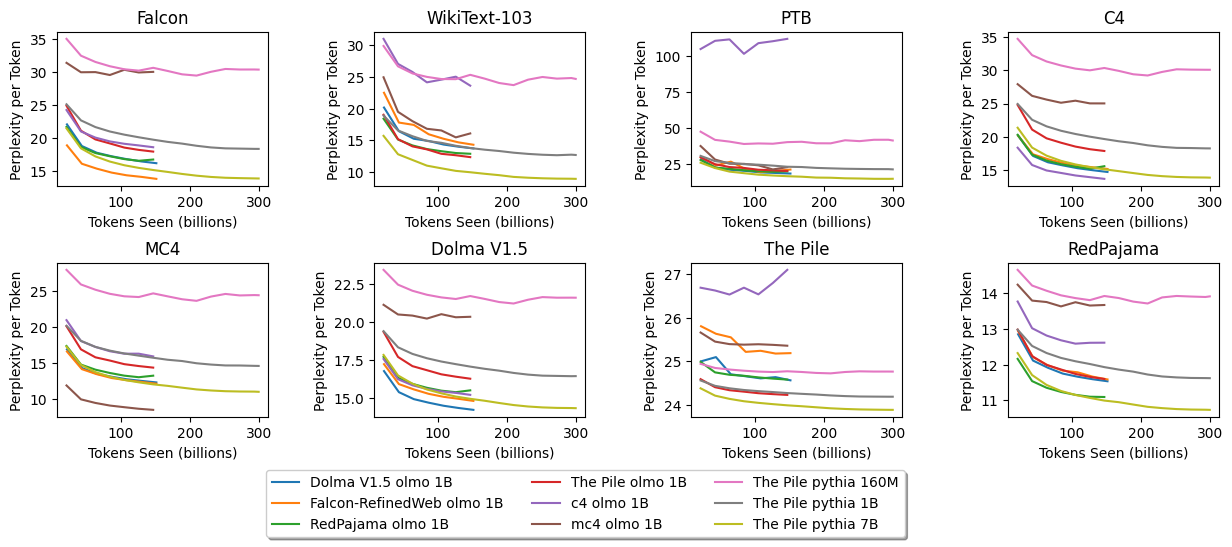

In [18]:
# all models over just one task

import matplotlib.pyplot as plt
import numpy as np

# subset_model_name_to_path = {k: v for k, v in model_name_to_path.items() if '160m' in k}
subset_model_name_to_path = model_name_to_path

# one subplot for each task

fig, axs = plt.subplots(len(all_standard_tasks)//4, 4, figsize=(15, 5), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

for i, task_name in enumerate(all_standard_tasks):
    

    models_over_one_task = get_task_metric_for_all_models(subset_model_name_to_path, task_name, metric_name)

    for (model, model_size, training_dataset), model_df in models_over_one_task.groupby(['model', 'model_size', 'training_dataset']):
        x_axis = model_df['tokens_seen'] / 1000000000
        y_axis = model_df[task_name]
        axs[i//4][i%4].plot(x_axis, y_axis, label=(training_dataset+' '+model+ f" {display_size(model_size)}"))
    axs[i//4][i%4].set_xlabel("Tokens Seen (billions)")
    axs[i//4][i%4].set_ylabel(name_to_display[metric_name])
    axs[i//4][i%4].set_title(name_to_display[task_name])
axs[-1][0].legend(loc='upper center', bbox_to_anchor=(2.5, -0.3),
        ncol=3, fancybox=True, shadow=True)
        # plt.plot(model_df['tokens_seen'] / 1000000000, model_df[task_name], label=(training_dataset+' '+model+ f" {model_size/1000000000:.0f}B"))
    # plt.legend()
# models_over_one_task = get_task_metric_for_all_models(model_name_to_path, 'ppl_dolma-v1_5', 'bits_per_byte')
# models_over_one_task

fig.savefig(os.path.join(FIGURE_DIR,'models_by_standard_benchmark.pdf'), bbox_inches='tight', dpi=300)


## Hill climb metric

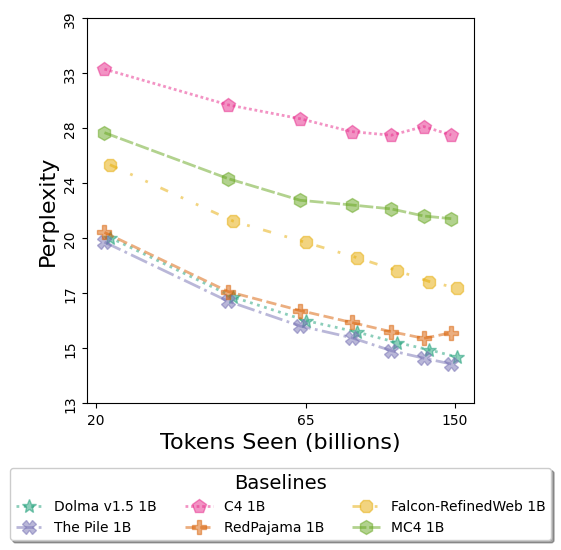

In [19]:
# one plot with lines for models by ppl over everything except disparities and fringe removing 100 PL 
def get_ppl_over_dolma_without_contaminated_data(model):
    ppl_per_subdomain = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model), "ppl_token_ppl_dolma-v1_5_subdomains.jsonl.gz")))
    assert ppl_per_subdomain['split'].iloc[0] == 'test', 'validation data is not yet supported'
    ppl_per_subdomain = ppl_per_subdomain.drop(columns=['stack_uniform'])
    tokens_per_domain = {
        'reddit_uniform': 494904,
        'common-crawl': 500000,
        'pes2o': 500000,
        'wiki': 500000,
        'books': 499999,
    }

    for domain, tokens in tokens_per_domain.items():
        ppl_per_subdomain[domain] = np.log(ppl_per_subdomain[domain]) * tokens
    ppl_per_subdomain['ppl_token'] = np.exp(ppl_per_subdomain[list(tokens_per_domain.keys())].sum(axis=1) / sum(tokens_per_domain.values()))
    ppl_per_subdomain['total_tokens'] = sum(tokens_per_domain.values())
    return ppl_per_subdomain[['ppl_token', 'total_tokens', 'tokens_seen']]


def get_ppl_over_tasks_by_tokens(model, tasks):
    ppl_metrics = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model), "ppl_metrics.jsonl.gz")))
    ppl_metrics = ppl_metrics[ppl_metrics['task'].isin(tasks)]
    dolma_deconned = get_ppl_over_dolma_without_contaminated_data(model)
    ppl_metrics[ppl_metrics['task'] == 'ppl_dolma-v1_5'].loc[:,['ppl_token', 'total_tokens', 'tokens_seen']] = dolma_deconned[['ppl_token', 'total_tokens', 'tokens_seen']]
    ppl_metrics['sum_logits'] = np.log(ppl_metrics['ppl_token']) * ppl_metrics['total_tokens']
    ppls_per_checkpoint = []
    for tokens_seen, group_df in ppl_metrics.groupby('tokens_seen'):
        sum_logits = group_df['sum_logits'].sum()
        total_tokens = group_df['total_tokens'].sum()
        ppl = np.exp(sum_logits / total_tokens)
        ppls_per_checkpoint.append({'tokens_seen': tokens_seen, 'ppl_token': ppl})
    return pd.DataFrame(ppls_per_checkpoint)

fig, ax = plt.subplots(figsize=(5, 5))

for model_name in trained_baseline_models:
    model_path = os.path.join(RESULTS_DIR, model_name_to_path[model_name])
    ppls_per_checkpoint = get_ppl_over_tasks_by_tokens(model_path, all_domains_clean)
    plt.plot(ppls_per_checkpoint['tokens_seen'] / 1000000000, np.log(np.log(ppls_per_checkpoint['ppl_token'])), label=name_to_display[model_name],
                marker=model_name_to_marker[model_name], color=model_name_to_color[model_name], alpha=0.5,
                markersize=10, linewidth=2, linestyle=model_name_to_linestyle[model_name])
ax.set_xscale('log')
ax.xaxis.set_minor_locator(plt.NullLocator())
xticks = [20, 65, 150]
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xticks])
ax.set_xlabel("Tokens Seen (billions)", fontsize=16)


ax.set_ylabel("Perplexity", fontsize=16)
y_ticks = ax.get_yticks()
y_ticks_transformed = np.exp(np.exp(y_ticks))
ax.set_yticks(y_ticks)
ax.set_yticklabels([human_readable_int(y) for y in y_ticks_transformed], rotation='vertical', ha='right', va='center')


# plt.legend()
# plt legend in one row along top
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
        ncol=3, fancybox=True, shadow=True, title='Baselines', title_fontsize=14)

# save as pdf
plt.savefig(os.path.join(FIGURE_DIR,'models_by_ppl_over_all_tasks.pdf'), bbox_inches='tight', dpi=300)



## Multi-domain Robustness

In [20]:
# a table ranking models by macro avg or win rate over subdomains from given tasks
def get_task_subdomains_results_files(results_files, metric_name, task_name):
    if task_name == 'All':
        # results_files_all_modified = [f for f in results_files_all if "ppl_dolma_100_programing_languages" not in f] # not decontaminated so remove from "all"
        # results_files_all_modified = [f for f in results_files_all_modified if "ppl_ice_fixed" not in f] # not public so remove from "all"
        # results_files_all_modified = [f for f in results_files_all_modified if "ppl_pile" not in f] # try without this since it bloews up falcon
        def test_func(x):
            return ('ppl_m2d2_s2orc_unsplit' in x or 'ppl_m2d2_wikipedia' in x or 'ppl_dolma_100_subreddits' in x or 'ppl_c4_100_domains' in x) and x.startswith('ppl_token')
        results_files_all_modified = [f for f in results_files_all if test_func(f)]
        return results_files_all_modified
    return [f for f in results_files if f.startswith(metric_name) and f.endswith(task_name + '_subdomains.jsonl.gz')]


def make_ranking_table(agg_function, metric_name, model_name_to_path, include_all_checkpoints=False, tasks=None):    
    tasks = list(domains_with_subdomains_clean) + ['All'] if tasks is None else tasks
    tasks_without_subdomains = set(task for task in tasks if task in domains_without_subdomains or task == 'ppl_manosphere_meta_sep')
    tasks_to_files = {
        task: get_task_subdomains_results_files(results_files_clean, metric_name, task) for task in tasks if task not in domains_without_subdomains and task != 'ppl_manosphere_meta_sep'
    }

    assert agg_function in {get_avg_over_all_subdomains, get_win_rate_over_all_subdomains, get_median_over_all_subdomains}
    if include_all_checkpoints:
        assert agg_function != get_win_rate_over_all_subdomains, 'win rates dont make sense for all checkpoints'
    all_dfs = []
    for task in tasks:
        all_models_dfs = []
        for i, (model_name, model) in enumerate(model_name_to_path.items()):
            model_path = os.path.join(RESULTS_DIR, model)
            if task in tasks_without_subdomains:
                task_all_subdomains = get_metric_for_all_subdomains(model_path, [], metric_name, {task_name})
                # continue 
            else:
                files = tasks_to_files[task]
                try:
                    task_all_subdomains = get_metric_for_all_subdomains(model_path, files, metric_name)
                except ValueError as e:
                    raise ValueError(f"Error for {task} {model_name} {model_path} {files}") from e
            # get just the final checkpoints by tokens seen for each model
            if not include_all_checkpoints:
                task_all_subdomains = task_all_subdomains.sort_values(by=['tokens_seen']).groupby(['model','model_size']).last().reset_index()
            all_models_dfs.append(task_all_subdomains)
        assert len(all_models_dfs), f"empty for {task}"
        all_models_dfs = pd.concat(all_models_dfs)
        all_models_dfs = agg_function(all_models_dfs)
        if 'avg_over_subdomains' in all_models_dfs:
            all_models_dfs.rename(columns={'avg_over_subdomains': task}, inplace=True)
        if 'win_rate_over_subdomains' in all_models_dfs:
            all_models_dfs.rename(columns={'win_rate_over_subdomains': task}, inplace=True)
        if 'median_over_subdomains' in all_models_dfs:
            all_models_dfs.rename(columns={'median_over_subdomains': task}, inplace=True)
        all_dfs.append(all_models_dfs)
    all_dfs = reduce(lambda left,right: pd.merge(left,right,on=list(shared_cols), how='outer'), all_dfs)

    return all_dfs


In [21]:
rankings_table = make_ranking_table(get_avg_over_all_subdomains, metric_name, model_name_to_path,).drop(columns=['tokens_seen','training_steps','split'])
rankings_table.rename(columns=name_to_display, inplace=True)
column_format = ('p{'+ str(1/ len(rankings_table.columns)*.5)+'\\textwidth}') * len(rankings_table.columns)
formaters = {name_to_display['model_size']: lambda x: display_size(x)}
rankings_table.to_latex(os.path.join(TABLES_DIR, 'final_checkpoints_avg_ppl_per_tasks.tex'), index=False, float_format="%.2f", column_format=column_format, formatters=formaters)
rankings_table

,Training Dataset,Model Size,Model,C4 100 Domains,100 Subreddits,M2D2 S2ORC,The Pile,M2D2 Wikipedia,Dolma V1.5,Twitter AAE,ICE,RedPajama,100 PLs,All
0,Dolma V1.5,1177240704,olmo,13.338549,20.325492,14.205593,12.071563,13.398732,12.609195,175.348682,15.487544,9.529943,3.572524,15.378162
1,The Pile,1177240704,olmo,14.706735,23.547606,12.277987,8.450213,12.602586,13.280128,203.305005,15.098326,8.549489,3.854354,15.611272
2,Falcon-RefinedWeb,1177240704,olmo,13.265275,24.652996,16.697323,3732.187010,13.641269,16.848770,169.487323,21.337623,21.121045,32.092361,17.434788
3,c4,1177240704,olmo,12.883863,31.887460,19.507539,394.615139,16.498378,27.503410,215.474689,237.284082,55915.308802,88.570194,20.555248
4,mc4,1177240704,olmo,24.581412,36.662167,16.733659,589.201685,15.698732,20.337594,230.332210,23.751490,15.258597,17.593758,23.285627
5,RedPajama,1177240704,olmo,13.608215,25.385918,14.508589,12.198283,12.376437,14.190600,468.556110,15.526775,8.326343,5.372171,16.663096
6,The Pile,85056000,pythia,24.980322,38.179903,19.873386,13.563294,21.847392,21.644417,369.915630,24.718647,13.739477,5.249504,25.735951
7,The Pile,805736448,pythia,15.015606,24.558751,12.339637,8.265756,12.654877,13.491730,224.727703,15.445682,8.662201,3.749775,15.959587
8,The Pile,6444163072,pythia,11.378526,18.866162,9.706912,6.226319,9.261965,10.382739,176.427283,12.233094,6.743793,3.232354,12.260195


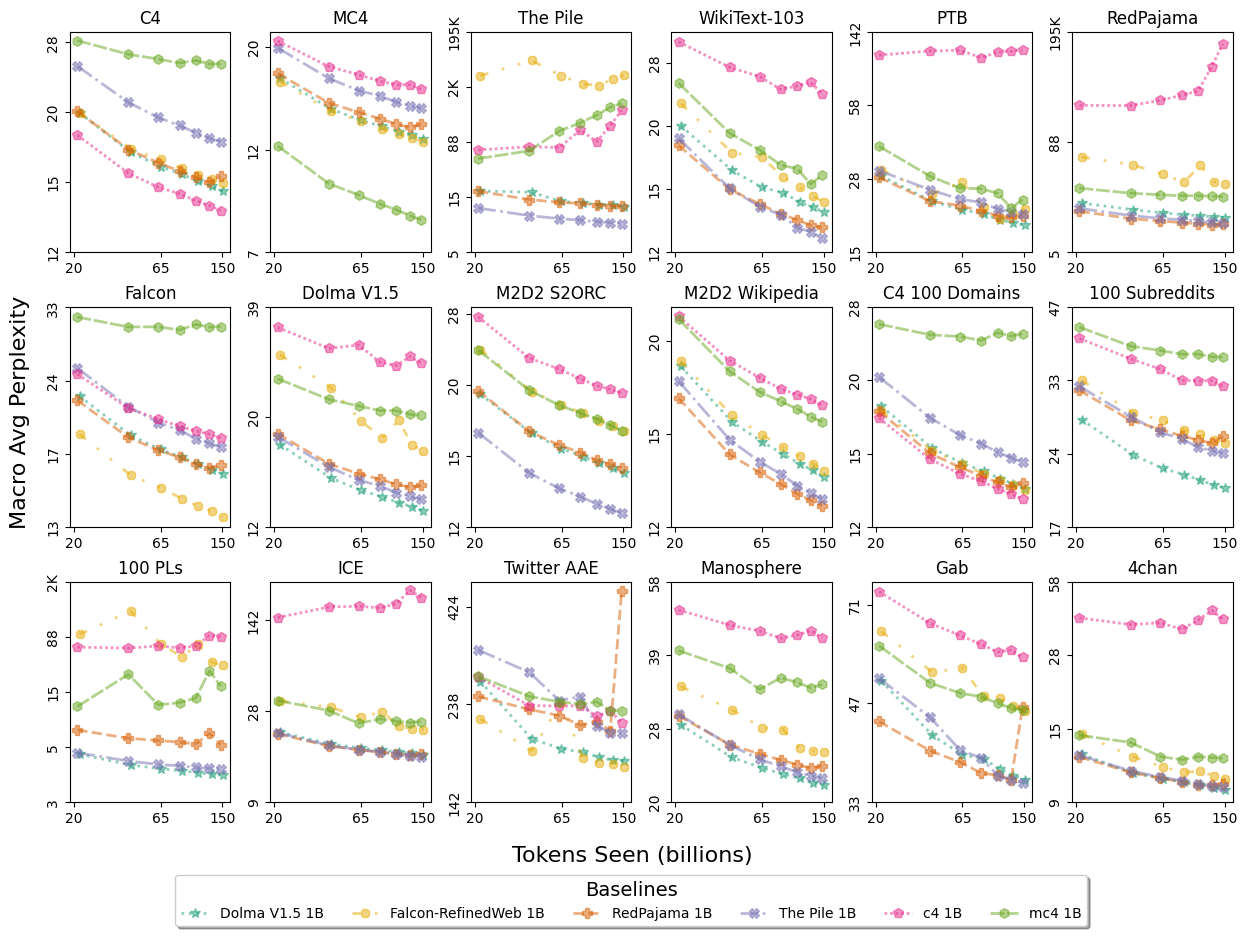

In [22]:
import matplotlib.pyplot as plt
import numpy as np

cols = 6
domains = ['ppl_'+domain for domain in domain_order]
models = {k:v for k,v in model_name_to_path.items() if k in trained_baseline_models}
# one subplot for each task
fig, axs = plt.subplots(len(domains)//cols + int(len(domains)//cols < len(domains)/cols), cols, figsize=(15, 10), gridspec_kw={'hspace': 0.25, 'wspace': 0.25})

for i, task_name in enumerate(domains):
    
    models_over_one_task = make_ranking_table(get_avg_over_all_subdomains, metric_name, models,include_all_checkpoints=True, tasks=[task_name])
    for (model, model_size, training_dataset), model_df in models_over_one_task.groupby(['model', 'model_size', 'training_dataset']):
        x_axis = model_df['tokens_seen'] / 1000000000
        y_axis = model_df[task_name]
        y_axis = np.log(np.log(y_axis))
        axs[i//cols][i%cols].plot(
            x_axis, y_axis, label=(training_dataset+ f" {display_size(model_size)}"),
            markersize=7, alpha=0.5, marker=model_dataset_names_to_marker[training_dataset+' '+model+ f" {display_size(model_size)}"],
            color=model_dataset_names_to_color[training_dataset+' '+model+ f" {display_size(model_size)}"],
            linestyle=model_dataset_names_to_linestyle[training_dataset+' '+model+ f" {display_size(model_size)}"],
            linewidth=2,
            )
    # if i // cols == len(axs) - 1:
    #     axs[i//cols][i%cols].set_xlabel("Tokens Seen (billions)")
    axs[i//cols][i%cols].set_xscale('log')
    axs[i//cols][i%cols].xaxis.set_minor_locator(plt.NullLocator())
    xticks = [20, 65, 150]
    axs[i//cols][i%cols].set_xticks(xticks)
    axs[i//cols][i%cols].set_xticklabels([str(x) for x in xticks])

    # if i % cols == 0:
        # axs[i//cols][i%cols].set_ylabel("Macro Avg Perplexity")
    # axs[i//cols][i%cols].set_ylabel("Macro Avg Perplexity") # +name_to_display[metric_name])
    y_ticks = axs[i//cols][i%cols].get_yticks()[::2]
    y_ticks_transformed = np.exp(np.exp(y_ticks))
    axs[i//cols][i%cols].set_yticks(y_ticks)
    axs[i//cols][i%cols].set_yticklabels([human_readable_int(y) for y in y_ticks_transformed], rotation='vertical', ha='right', va='center')
    axs[i//cols][i%cols].set_title(name_to_display[task_name])
axs[-1][0].legend(loc='upper center', bbox_to_anchor=(3.5, -0.3),
        ncol=6, fancybox=True, shadow=True, title='Baselines', title_fontsize=14)

fig.text(0.085, 0.5, 'Macro Avg Perplexity', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 0.05, 'Tokens Seen (billions)', ha='center', fontsize=16)


fig.savefig(os.path.join(FIGURE_DIR,'models_by_macro_subdomains.pdf'), bbox_inches='tight', dpi=300)

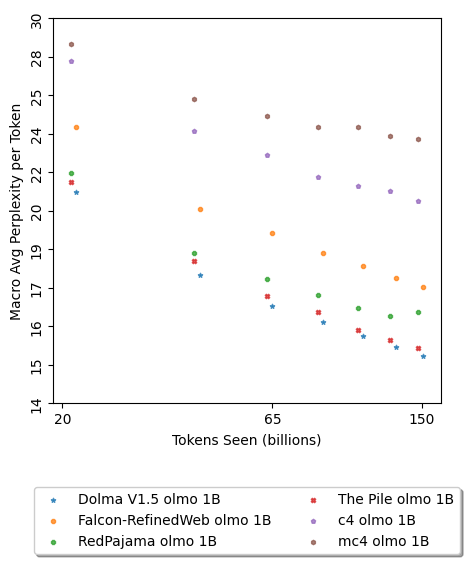

In [23]:
import matplotlib.pyplot as plt
import numpy as np

cols = 1
domains = list(['All'])
models = {k:v for k,v in model_name_to_path.items() if k in trained_baseline_models}
# one subplot for each task
fig, axs = plt.subplots(len(domains)//cols + int(len(domains)//cols < len(domains)/cols), cols, figsize=(5, 5), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})
axs = [[axs]]

for i, task_name in enumerate(domains):
    
    models_over_one_task = make_ranking_table(get_avg_over_all_subdomains, metric_name, models,include_all_checkpoints=True, tasks=[task_name]) # get_avg_over_all_subdomains

    for (model, model_size, training_dataset), model_df in models_over_one_task.groupby(['model', 'model_size', 'training_dataset']):
        x_axis = model_df['tokens_seen'] / 1000000000
        y_axis = model_df[task_name]
        y_axis = np.log(np.log(y_axis))
        axs[i//cols][i%cols].scatter(x_axis, y_axis, label=(training_dataset+' '+model+ f" {display_size(model_size)}"), s=10, alpha=0.75, marker=model_dataset_names_to_marker[training_dataset+' '+model+ f" {display_size(model_size)}"])
    axs[i//cols][i%cols].set_xlabel("Tokens Seen (billions)")
    axs[i//cols][i%cols].set_xscale('log')
    axs[i//cols][i%cols].xaxis.set_minor_locator(plt.NullLocator())
    xticks = [20, 65, 150]
    axs[i//cols][i%cols].set_xticks(xticks)
    axs[i//cols][i%cols].set_xticklabels([str(x) for x in xticks])
    
    axs[i//cols][i%cols].set_ylabel("Macro Avg " +name_to_display[metric_name])
    y_ticks = axs[i//cols][i%cols].get_yticks()
    y_ticks_transformed = np.exp(np.exp(y_ticks))
    axs[i//cols][i%cols].set_yticks(y_ticks)
    axs[i//cols][i%cols].set_yticklabels([human_readable_int(y) for y in y_ticks_transformed], rotation='vertical', ha='right', va='center')

    # axs[i//cols][i%cols].set_title(name_to_display[task_name])
axs[-1][0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
        ncol=2, fancybox=True, shadow=True)

# fig.savefig(os.path.join(FIGURE_DIR,'models_by_macro_subdomains_all.pdf'), bbox_inches='tight', dpi=300)

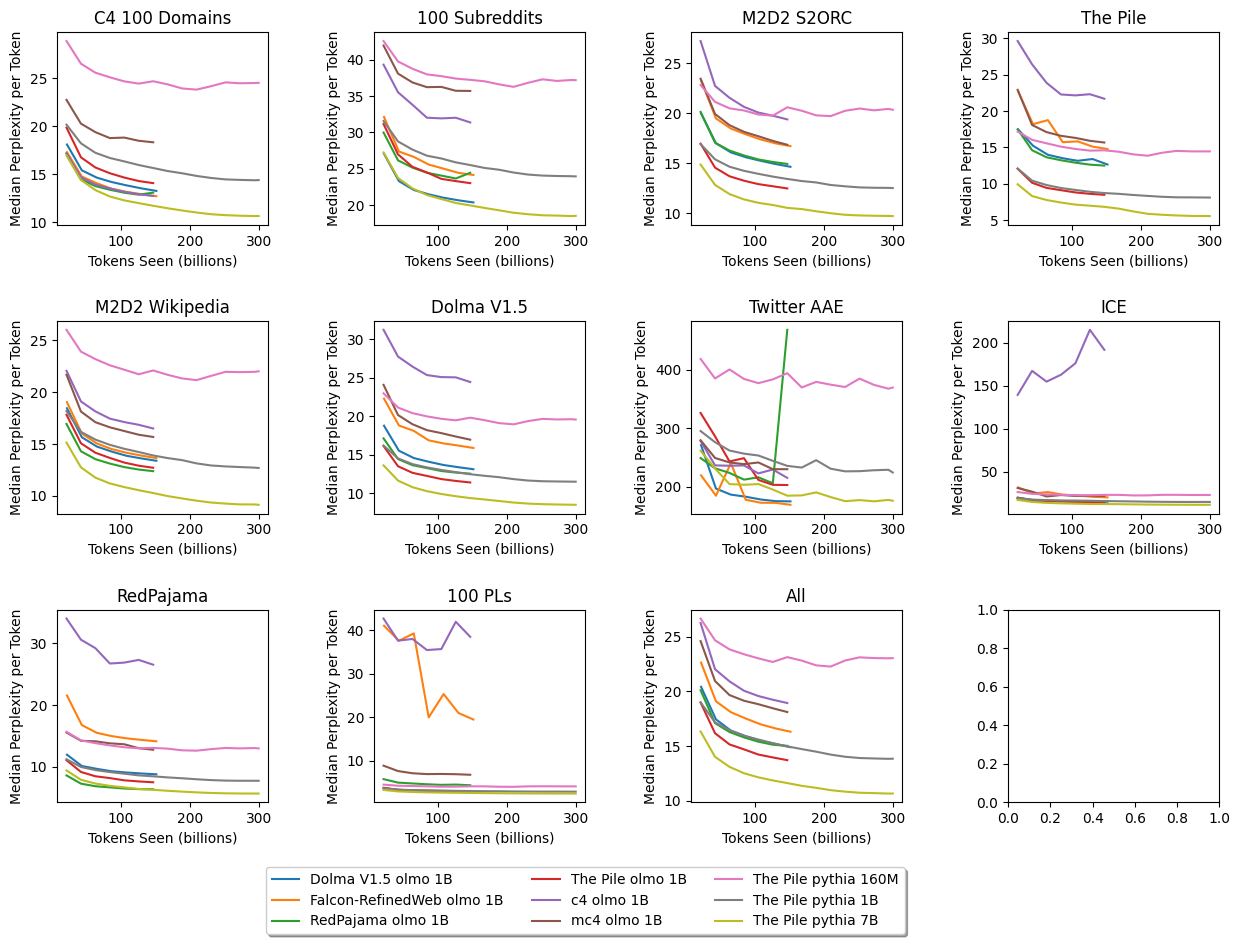

In [24]:
import matplotlib.pyplot as plt
import numpy as np

cols = 4
# one subplot for each task
fig, axs = plt.subplots(len(list(domains_with_subdomains_clean) + ['All'])//cols + int(len(list(domains_with_subdomains_clean) + ['All'])//cols < len(list(domains_with_subdomains_clean) + ['All'])/cols), cols, figsize=(15, 10), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

for i, task_name in enumerate(list(domains_with_subdomains_clean) + ['All']):
    
    models_over_one_task = make_ranking_table(get_median_over_all_subdomains, metric_name, model_name_to_path,include_all_checkpoints=True, tasks=[task_name])

    for (model, model_size, training_dataset), model_df in models_over_one_task.groupby(['model', 'model_size', 'training_dataset']):
        x_axis = model_df['tokens_seen'] / 1000000000
        y_axis = model_df[task_name]
        axs[i//cols][i%cols].plot(x_axis, y_axis, label=(training_dataset+' '+model+ f" {display_size(model_size)}"))
    axs[i//cols][i%cols].set_xlabel("Tokens Seen (billions)")
    axs[i//cols][i%cols].set_ylabel("Median " +name_to_display[metric_name])
    axs[i//cols][i%cols].set_title(name_to_display[task_name])
axs[-1][0].legend(loc='upper center', bbox_to_anchor=(2.5, -0.3),
        ncol=3, fancybox=True, shadow=True)

# fig.savefig(os.path.join(FIGURE_DIR,'models_by_median_subdomains.pdf'), bbox_inches='tight', dpi=300)

### Non-aggregated subdomain results

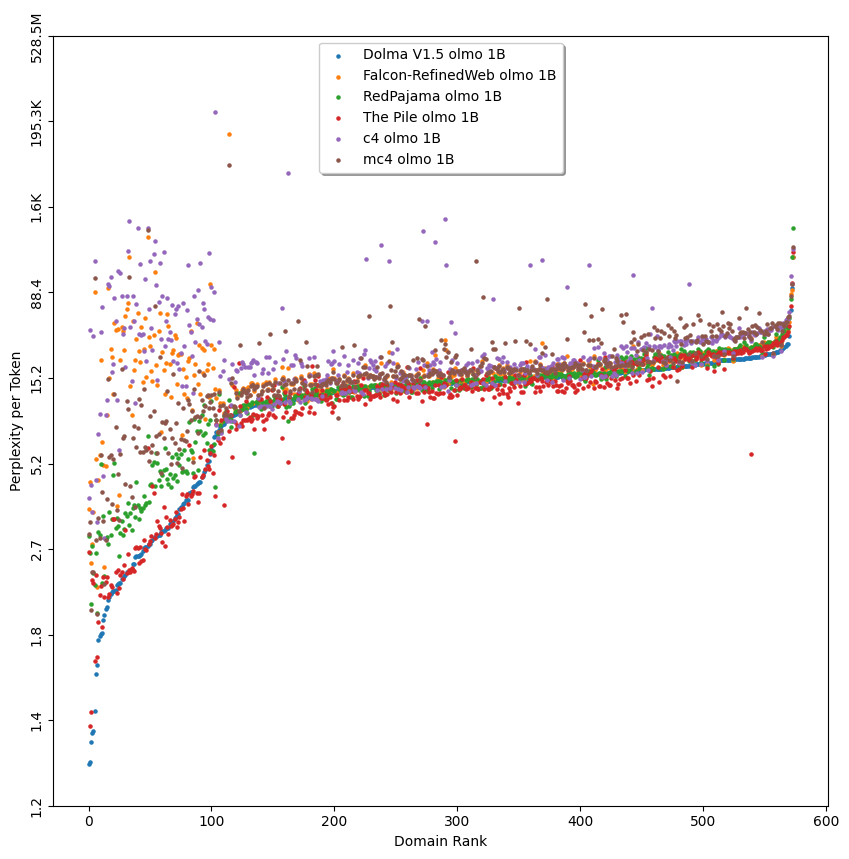

In [25]:
# sort domains by their performance on the final checkpoint of Dolma 7b, then scatter plot for each model in its own color ordered that way


# get subdomains in order of a model's BPB on the final checkpoint
model_name = 'dolma-1b'
model = model_name_to_path[model_name]
model_path = os.path.join(RESULTS_DIR, model)
all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, metric_name, domains_without_subdomains_clean)
unaggred_subdomains= all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()]
tmp_df = unaggred_subdomains.drop(columns=shared_cols)
assert len(tmp_df) == 1
dolma_domains_as_rows = tmp_df.T.rename(columns={tmp_df.T.columns[0]: 'metric'}).sort_values(by='metric', axis=0).index

# get all subdomains
unaggred_subdomains = []
models = {k:v for k,v in model_name_to_path.items() if k in trained_baseline_models}
for i, (model_name, model) in enumerate(models.items()):
    model_path = os.path.join(RESULTS_DIR, model)
    all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, metric_name, domains_without_subdomains_clean)
    unaggred_subdomains.append(all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()])

unaggred_subdomains = pd.concat(unaggred_subdomains)
sorted_unaggred_subdomains = unaggred_subdomains[list(shared_cols) + list(dolma_domains_as_rows)]

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

for (model, model_size, training_dataset), model_df in sorted_unaggred_subdomains.groupby(['model', 'model_size', 'training_dataset']):
    y_axis = model_df[list(dolma_domains_as_rows)].values[0]
    x_axis = np.arange(len(dolma_domains_as_rows))
    y_axis = np.log(np.log(y_axis))
    # smaller scatter point size
    axs.scatter(x_axis, y_axis, label=(training_dataset+' '+model+ f" {display_size(model_size)}"), s=5)
axs.set_xlabel("Domain Rank")
axs.set_ylabel(name_to_display[metric_name])
y_ticks = axs.get_yticks()
y_ticks_transformed = np.exp(np.exp(y_ticks))
axs.set_yticks(y_ticks)
axs.set_yticklabels([human_readable_int(y, precision=1) for y in y_ticks_transformed], rotation='vertical', ha='right', va='center')
axs.legend(loc='upper center', ncol=1, fancybox=True, shadow=True)

fig.savefig(os.path.join(FIGURE_DIR,'subdomain_perf_ordered.pdf'), bbox_inches='tight', dpi=300)


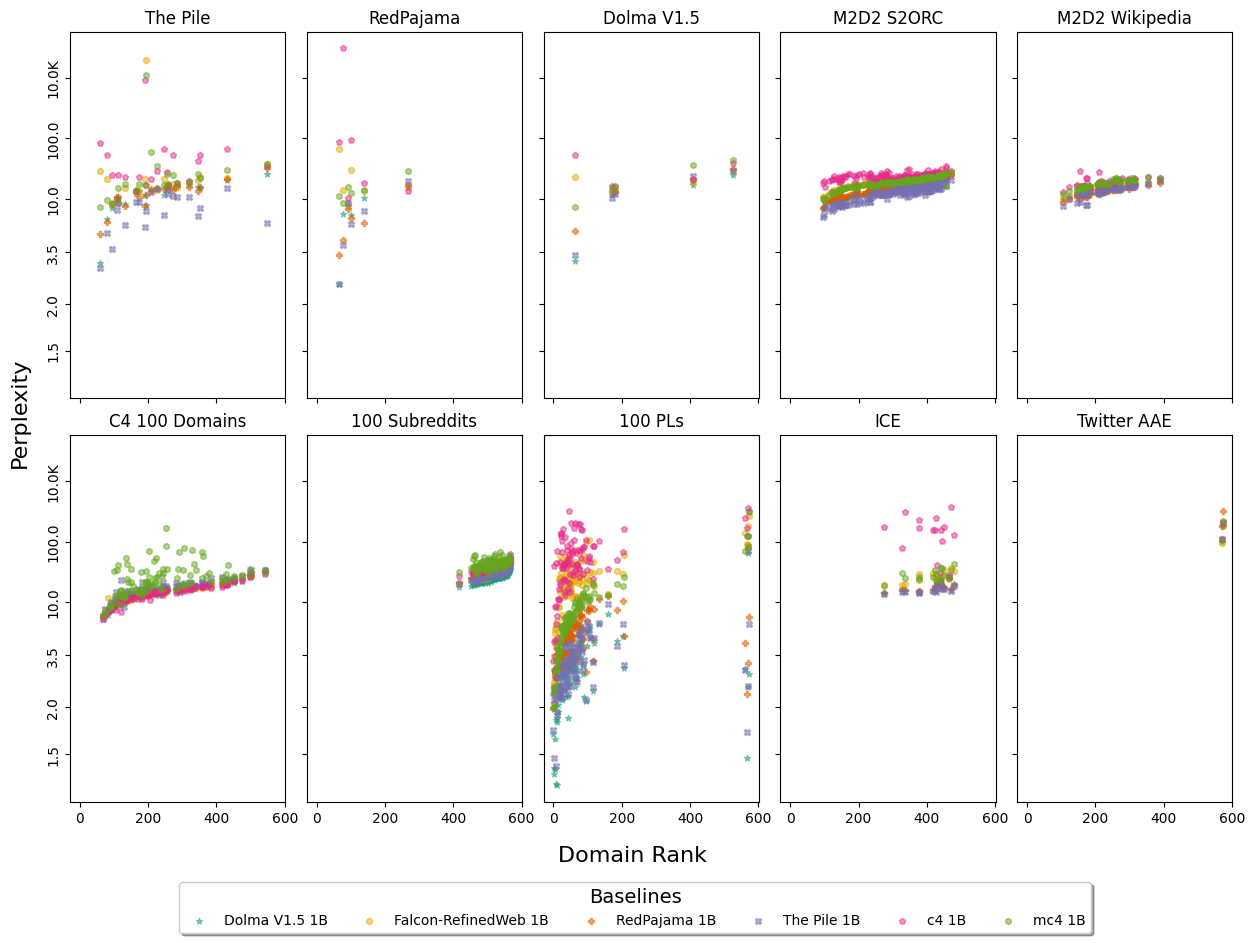

In [26]:
# get subdomains in order of avg model's ppl on the final checkpoint
model_name = 'dolma-1b'
model = model_name_to_path[model_name]
model_path = os.path.join(RESULTS_DIR, model)
domains_by_tasks = {}
# all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, metric_name, domains_without_subdomains_clean)
# unaggred_subdomains= all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()]
# tmp_df = unaggred_subdomains.drop(columns=shared_cols)
# assert len(tmp_df) == 1
# dolma_domains_as_rows = tmp_df.T.rename(columns={tmp_df.T.columns[0]: 'metric'}).sort_values(by='metric', axis=0).index

cols = 5
tasks = ['ppl_'+domain for domain in domain_order if ('ppl_'+domain) in (domains_with_subdomains - {'ppl_manosphere_meta_sep'})]
fig, axs = plt.subplots(len(tasks) // cols, cols, figsize=(15, 10), sharex=True, sharey=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

unaggred_subdomains = []
models = {k:v for k,v in model_name_to_path.items() if k in trained_baseline_models}
for i, (model_name, model) in enumerate(models.items()):
    model_path = os.path.join(RESULTS_DIR, model)
    all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, metric_name, domains_without_subdomains_clean)
    unaggred_subdomains.append(all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()])

unaggred_subdomains = pd.concat(unaggred_subdomains)

# get avg over all subdomains
tmp_df = unaggred_subdomains.drop(columns=shared_cols)
dolma_domains_as_rows = tmp_df.median().sort_values(ascending=True).index

sorted_unaggred_subdomains = unaggred_subdomains[list(shared_cols) + list(dolma_domains_as_rows)]

# sorted_unaggred_subdomains = unaggred_subdomains[list(shared_cols) + list(dolma_domains_as_rows)]

for j, (task) in enumerate(tasks):
    domains = task_to_domains[task]
    for (model, model_size, training_dataset), model_df in sorted_unaggred_subdomains.groupby(['model', 'model_size', 'training_dataset']):
        domains_in_order = [domain for domain in dolma_domains_as_rows if domain in domains]
        y_axis = model_df[domains_in_order]
        x_axis = [i for i, domain in enumerate(dolma_domains_as_rows) if domain in domains]
        y_axis = np.log(np.log(y_axis))
        # smaller scatter point size
        axs[j//cols][j%cols].scatter(x_axis, y_axis, label=(training_dataset+ f" {display_size(model_size)}"), s=20, alpha=0.5, marker=model_dataset_names_to_marker[training_dataset+' '+model+ f" {display_size(model_size)}"],
            color=model_dataset_names_to_color[training_dataset+' '+model+ f" {display_size(model_size)}"])
    # if j // cols == len(axs) - 1:
    #     axs[j//cols][j%cols].set_xlabel("Domain Rank")
    # axs[j//cols][j%cols].set_xlabel("Domain Rank")
    # if j % cols == 0:
    #     axs[j//cols][j%cols].set_ylabel("Perplexity")
    # axs[j//cols][j%cols].set_ylabel(name_to_display[metric_name])
    y_ticks = np.log(np.log([1.5, 2, 3.5, 10, 100, 10000]))
    y_ticks_transformed = np.exp(np.exp(y_ticks))
    axs[j//cols][j%cols].set_yticks(y_ticks)
    axs[j//cols][j%cols].set_yticklabels([human_readable_int(y, precision=1) for y in y_ticks_transformed], rotation='vertical', ha='right', va='center')
    axs[j//cols][j%cols].set_title(name_to_display[task])
    
axs[-1][0].legend(loc='upper center', bbox_to_anchor=(2.625, -0.2),
        ncol=6, fancybox=True, shadow=True, title='Baselines', title_fontsize=14)

fig.text(0.5, 0.05, 'Domain Rank', ha='center', fontsize=16)
fig.text(0.085, 0.5, 'Perplexity', va='center', rotation='vertical', fontsize=16)

fig.savefig(os.path.join(FIGURE_DIR,'subdomain_perf_ordered_by_task.pdf'), bbox_inches='tight', dpi=300)


### different improvement rates

pile-1b
ppl_m2d2_s2orc_unsplit
stat.ME   -0.098829
Name: 0, dtype: float64
pile-1b
ppl_dolma_100_programing_languages
45_pascal   -0.114282
Name: 0, dtype: float64
falcon-1b
ppl_pile
Ubuntu_IRC   -0.039048
Name: 0, dtype: float64
rpj-1b
ppl_twitterAAE_HELM_fixed
white   -0.817622
AA      -0.901763
Name: 0, dtype: float64


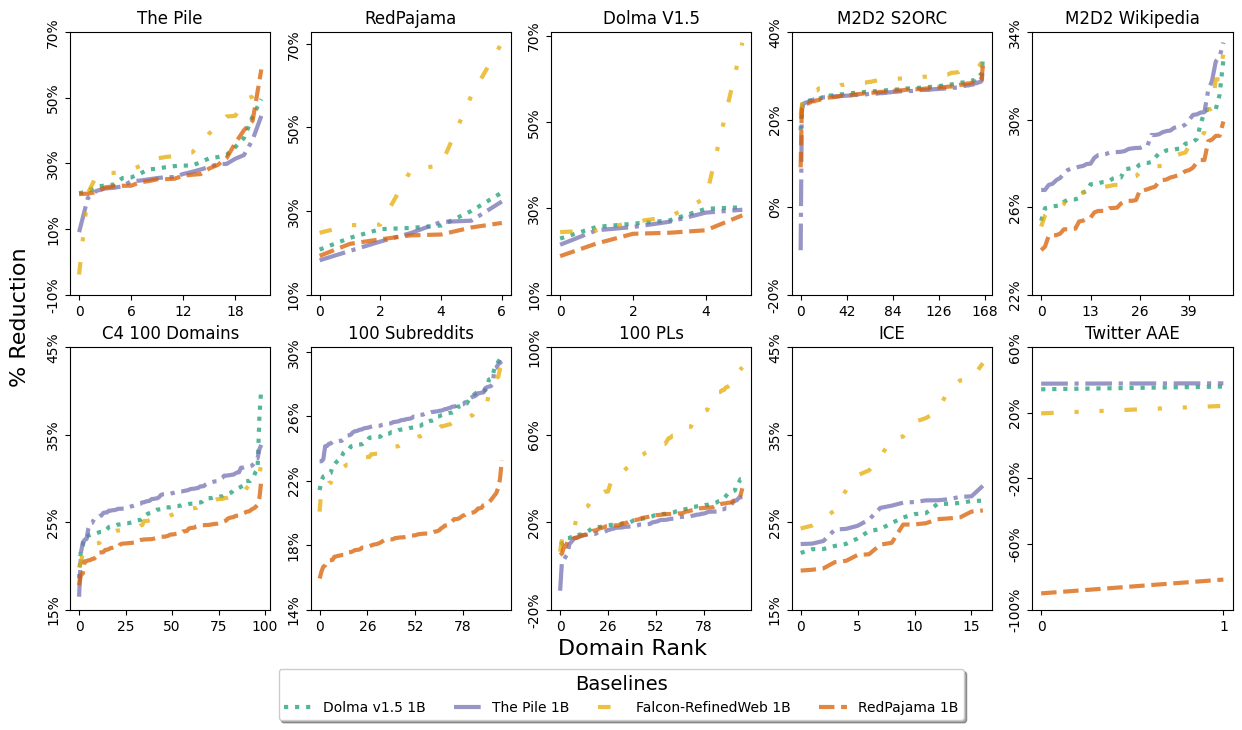

In [57]:
import matplotlib
cols = 5
# models = {k:v for k,v in model_name_to_path.items() if k in trained_baseline_models}
models = {k:v for k,v in model_name_to_path.items() if k in {'dolma-1b', 'pile-1b', 'rpj-1b', 'falcon-1b'}}
# models = {k:v for k,v in model_name_to_path.items() if k in {'c4-1b', 'mc4-1b'}}
tasks = ['ppl_'+domain for domain in domain_order if ('ppl_'+domain) in (domains_with_subdomains - {'ppl_manosphere_meta_sep'})]
fig, axs = plt.subplots(len(task_to_domains) // cols, cols, figsize=(15, 7.5), gridspec_kw={'hspace': 0.2, 'wspace': 0.2})
most_improved_domains = {}
least_improved_domains = {}
range_per_task = {}
prev_range_per_task = {}
for i, (model_name, model) in enumerate(models.items()):
    most_improved_domains[model_name] = {}
    least_improved_domains[model_name] = {}
    for j, task_name in enumerate(tasks):
        task_files = get_task_subdomains_results_files(results_files_clean, metric_name, task_name)
        model_path = os.path.join(RESULTS_DIR, model)
        all_subdomains = get_metric_for_all_subdomains(model_path, task_files, metric_name)
        max_all_subdomains = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()].reset_index(drop=True)
        min_all_subdomains = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].min()].reset_index(drop=True)
        domains = list(tasts_to_domains_clean[task_name])
        ratio_by_subdomain = 1 - max_all_subdomains[domains] / min_all_subdomains[domains]
        ratio_by_subdomain_series = ratio_by_subdomain.iloc[0].T
        negative_reduction = ratio_by_subdomain_series[ratio_by_subdomain_series < 0.0]

        most_improved = ratio_by_subdomain_series.sort_values(ascending=False)
        most_improved_domains[model_name][task_name] = {}
        most_improved_domains[model_name][task_name]['domain'] = most_improved.index[0]
        most_improved_domains[model_name][task_name]['reduction'] = f"{most_improved.iloc[0]:.2%}"

        least_improved_domains[model_name][task_name] = {}
        least_improved_domains[model_name][task_name]['domain'] = most_improved.index[-1]
        least_improved_domains[model_name][task_name]['reduction'] = f"{most_improved.iloc[-1]:.2%}"
        
        if len(negative_reduction):
            print(model_name)
            print(task_name)
            print(negative_reduction)
        ratio_by_subdomain = ratio_by_subdomain.values.flatten()
        ratio_by_subdomain.sort()
        y_axis = ratio_by_subdomain
        previous_range = range_per_task.get(task_name, (1e30, -1e30))
        if task_name not in prev_range_per_task:
            prev_range_per_task[task_name] = {}
        if min(y_axis) < previous_range[0]:
            prev_range_per_task[task_name]['min'] = previous_range[0]
        if max(y_axis) > previous_range[1]:
            prev_range_per_task[task_name]['max'] = previous_range[1]
        range_per_task[task_name] = (min(min(y_axis), previous_range[0]), max(max(y_axis), previous_range[1]))
        x_axis = np.arange(len(ratio_by_subdomain))
        # axs[j//cols][j%cols].scatter(x_axis, y_axis, label=(name_to_display[model_name]),  s=20, alpha=0.5, marker=model_name_to_marker[model_name], color=model_name_to_color[model_name])
        axs[j//cols][j%cols].plot(x_axis, y_axis, label=(name_to_display[model_name]), alpha=0.75, color=model_name_to_color[model_name], linestyle= model_name_to_linestyle[model_name], linewidth=3)

        # if j // cols == len(axs) - 1:
        #     axs[j//cols][j%cols].set_xlabel("Domain Rank")
        # # axs[j//cols][j%cols].set_xlabel("Domain Rank")

        # if j % cols == 0:
        #     axs[j//cols][j%cols].set_ylabel("% Reduction Perplexity")
        # axs[j//cols][j%cols].set_ylabel("% Reduction " +name_to_display[metric_name])
        axs[j//cols][j%cols].set_title(name_to_display[task_name])
        # x ticks as integers
        axs[j//cols][j%cols].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(len(ratio_by_subdomain)//4 + 1))
        # y ticks as percentages
        axs[j//cols][j%cols].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0, decimals=0))
        # print(len(ratio_by_subdomain))
        # axs[j//cols][j%cols].set_xlim(0, len(ratio_by_subdomain))

for j in range(len(tasks)):
    pass
    # axs[j//cols][j%cols].set_yscale('symlog')
    # y_max = range_per_task[tasks[j]][1]
    # y_min = range_per_task[tasks[j]][0]
    # print(tasks[j])
    # print(y_max)
    # print(y_min)
    # if y_min < -5.0:
    #     print ("here")
    #     print(y_min)
    #     y_min = prev_range_per_task[tasks[j]]['min']
    #     print(y_min)
    # axs[j//cols][j%cols].set_ylim(y_min -0.05 , y_max  + 0.05)
    y_ticks = axs[j//cols][j%cols].get_yticks()[::2]
    axs[j//cols][j%cols].set_yticks(y_ticks)
    axs[j//cols][j%cols].set_yticklabels([f"{y:.0%}" for y in y_ticks], rotation='vertical', ha='right', va='center')
    

axs[-1][0].legend(loc='upper center', bbox_to_anchor=(2.75, -0.2),
        ncol=4, fancybox=True, shadow=True, title='Baselines', title_fontsize=14)

fig.text(0.5, 0.05, 'Domain Rank', ha='center', fontsize=16)
fig.text(0.085, 0.5, '% Reduction', va='center', rotation='vertical', fontsize=16)


fig.savefig(os.path.join(FIGURE_DIR,'domains_by_reduction_non_cc_and_falcon.pdf'), bbox_inches='tight', dpi=300)

c4-1b
ppl_pile
ArXiv            -11.385270
Github            -0.060681
StackExchange     -0.016727
PubMed_Central    -0.518820
Name: 0, dtype: float64
c4-1b
ppl_redpajama
arxiv           -113.342904
github            -0.196485
stackexchange     -0.488409
Name: 0, dtype: float64
c4-1b
ppl_dolma_100_programing_languages
16_rust                -0.083522
31_lua                 -0.167347
88_smarty              -0.767488
76_glsl                -0.034360
90_stata               -0.284837
20_vue                 -1.596567
44_mathematica         -0.143054
51_visual-basic        -0.054010
45_pascal              -1.022883
83_dockerfile          -0.250809
78_haxe                -0.368864
52_powershell          -0.200114
72_nix                 -0.450629
71_cuda                -0.034736
59_twig                -0.373929
65_erlang              -0.092249
95_asp                 -0.058745
26_tex                 -0.603027
36_jsx                 -1.621037
12_typescript          -0.923669
50_edn              

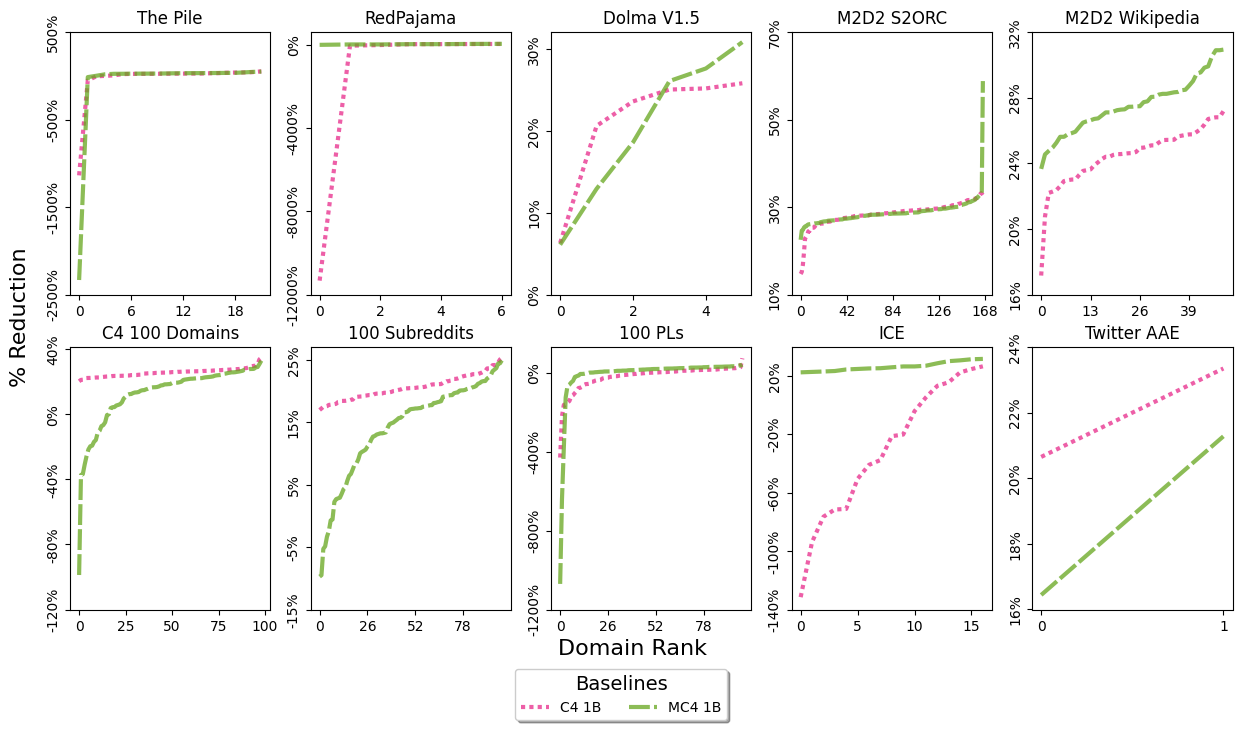

In [58]:
import matplotlib
cols = 5
# models = {k:v for k,v in model_name_to_path.items() if k in trained_baseline_models}
# models = {k:v for k,v in model_name_to_path.items() if k in {'dolma-1b', 'pile-1b', 'rpj-1b'}}
models = {k:v for k,v in model_name_to_path.items() if k in {'c4-1b', 'mc4-1b'}}
tasks = ['ppl_'+domain for domain in domain_order if ('ppl_'+domain) in (domains_with_subdomains - {'ppl_manosphere_meta_sep'})]
fig, axs = plt.subplots(len(task_to_domains) // cols, cols, figsize=(15, 7.5), gridspec_kw={'hspace': 0.2, 'wspace': 0.2})
most_improved_domains = {}
least_improved_domains = {}
range_per_task = {}
prev_range_per_task = {}
for i, (model_name, model) in enumerate(models.items()):
    most_improved_domains[model_name] = {}
    least_improved_domains[model_name] = {}
    for j, task_name in enumerate(tasks):
        task_files = get_task_subdomains_results_files(results_files_clean, metric_name, task_name)
        model_path = os.path.join(RESULTS_DIR, model)
        all_subdomains = get_metric_for_all_subdomains(model_path, task_files, metric_name)
        max_all_subdomains = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()].reset_index(drop=True)
        min_all_subdomains = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].min()].reset_index(drop=True)
        domains = list(tasts_to_domains_clean[task_name])
        ratio_by_subdomain = 1 - max_all_subdomains[domains] / min_all_subdomains[domains]
        ratio_by_subdomain_series = ratio_by_subdomain.iloc[0].T
        negative_reduction = ratio_by_subdomain_series[ratio_by_subdomain_series < 0.0]

        most_improved = ratio_by_subdomain_series.sort_values(ascending=False)
        most_improved_domains[model_name][task_name] = {}
        most_improved_domains[model_name][task_name]['domain'] = most_improved.index[0]
        most_improved_domains[model_name][task_name]['reduction'] = f"{most_improved.iloc[0]:.2%}"

        least_improved_domains[model_name][task_name] = {}
        least_improved_domains[model_name][task_name]['domain'] = most_improved.index[-1]
        least_improved_domains[model_name][task_name]['reduction'] = f"{most_improved.iloc[-1]:.2%}"
        
        if len(negative_reduction):
            print(model_name)
            print(task_name)
            print(negative_reduction)
        ratio_by_subdomain = ratio_by_subdomain.values.flatten()
        ratio_by_subdomain.sort()
        y_axis = ratio_by_subdomain
        previous_range = range_per_task.get(task_name, (1e30, -1e30))
        if task_name not in prev_range_per_task:
            prev_range_per_task[task_name] = {}
        if min(y_axis) < previous_range[0]:
            prev_range_per_task[task_name]['min'] = previous_range[0]
        if max(y_axis) > previous_range[1]:
            prev_range_per_task[task_name]['max'] = previous_range[1]
        range_per_task[task_name] = (min(min(y_axis), previous_range[0]), max(max(y_axis), previous_range[1]))
        x_axis = np.arange(len(ratio_by_subdomain))
        # axs[j//cols][j%cols].scatter(x_axis, y_axis, label=(name_to_display[model_name]),  s=20, alpha=0.5, marker=model_name_to_marker[model_name], color=model_name_to_color[model_name])
        axs[j//cols][j%cols].plot(x_axis, y_axis, label=(name_to_display[model_name]), alpha=0.75, color=model_name_to_color[model_name], linestyle=model_name_to_linestyle[model_name], linewidth=3)

        # if j // cols == len(axs) - 1:
        #     axs[j//cols][j%cols].set_xlabel("Domain Rank")
        # # axs[j//cols][j%cols].set_xlabel("Domain Rank")

        # if j % cols == 0:
        #     axs[j//cols][j%cols].set_ylabel("% Reduction Perplexity")
        # axs[j//cols][j%cols].set_ylabel("% Reduction " +name_to_display[metric_name])
        axs[j//cols][j%cols].set_title(name_to_display[task_name])
        # x ticks as integers
        axs[j//cols][j%cols].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(len(ratio_by_subdomain)//4 + 1))
        # y ticks as percentages
        axs[j//cols][j%cols].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0, decimals=0))
        # print(len(ratio_by_subdomain))
        # axs[j//cols][j%cols].set_xlim(0, len(ratio_by_subdomain))

for j in range(len(tasks)):
    pass
    # axs[j//cols][j%cols].set_yscale('symlog')
    # y_max = range_per_task[tasks[j]][1]
    # y_min = range_per_task[tasks[j]][0]
    # print(tasks[j])
    # print(y_max)
    # print(y_min)
    # if y_min < -5.0:
    #     print ("here")
    #     print(y_min)
    #     y_min = prev_range_per_task[tasks[j]]['min']
    #     print(y_min)
    # axs[j//cols][j%cols].set_ylim(y_min -0.05 , y_max  + 0.05)
    y_ticks = axs[j//cols][j%cols].get_yticks()[::2]
    axs[j//cols][j%cols].set_yticks(y_ticks)
    axs[j//cols][j%cols].set_yticklabels([f"{y:.0%}" for y in y_ticks], rotation='vertical', ha='right', va='center')
    

axs[-1][0].legend(loc='upper center', bbox_to_anchor=(2.75, -0.2),
        ncol=4, fancybox=True, shadow=True, title='Baselines', title_fontsize=14)

fig.text(0.5, 0.05, 'Domain Rank', ha='center', fontsize=16)
fig.text(0.085, 0.5, '% Reduction', va='center', rotation='vertical', fontsize=16)


fig.savefig(os.path.join(FIGURE_DIR,'domains_by_reduction_cc_except_falcon.pdf'), bbox_inches='tight', dpi=300)

pile-1b
ppl_m2d2_s2orc_unsplit
stat.ME   -0.098829
Name: 0, dtype: float64
pile-1b
ppl_dolma_100_programing_languages
45_pascal   -0.114282
Name: 0, dtype: float64
falcon-1b
ppl_pile
Ubuntu_IRC   -0.039048
Name: 0, dtype: float64
c4-1b
ppl_pile
ArXiv            -11.385270
Github            -0.060681
StackExchange     -0.016727
PubMed_Central    -0.518820
Name: 0, dtype: float64
c4-1b
ppl_redpajama
arxiv           -113.342904
github            -0.196485
stackexchange     -0.488409
Name: 0, dtype: float64
c4-1b
ppl_dolma_100_programing_languages
16_rust                -0.083522
31_lua                 -0.167347
88_smarty              -0.767488
76_glsl                -0.034360
90_stata               -0.284837
20_vue                 -1.596567
44_mathematica         -0.143054
51_visual-basic        -0.054010
45_pascal              -1.022883
83_dockerfile          -0.250809
78_haxe                -0.368864
52_powershell          -0.200114
72_nix                 -0.450629
71_cuda              

Text(0.085, 0.5, '% Reduction')

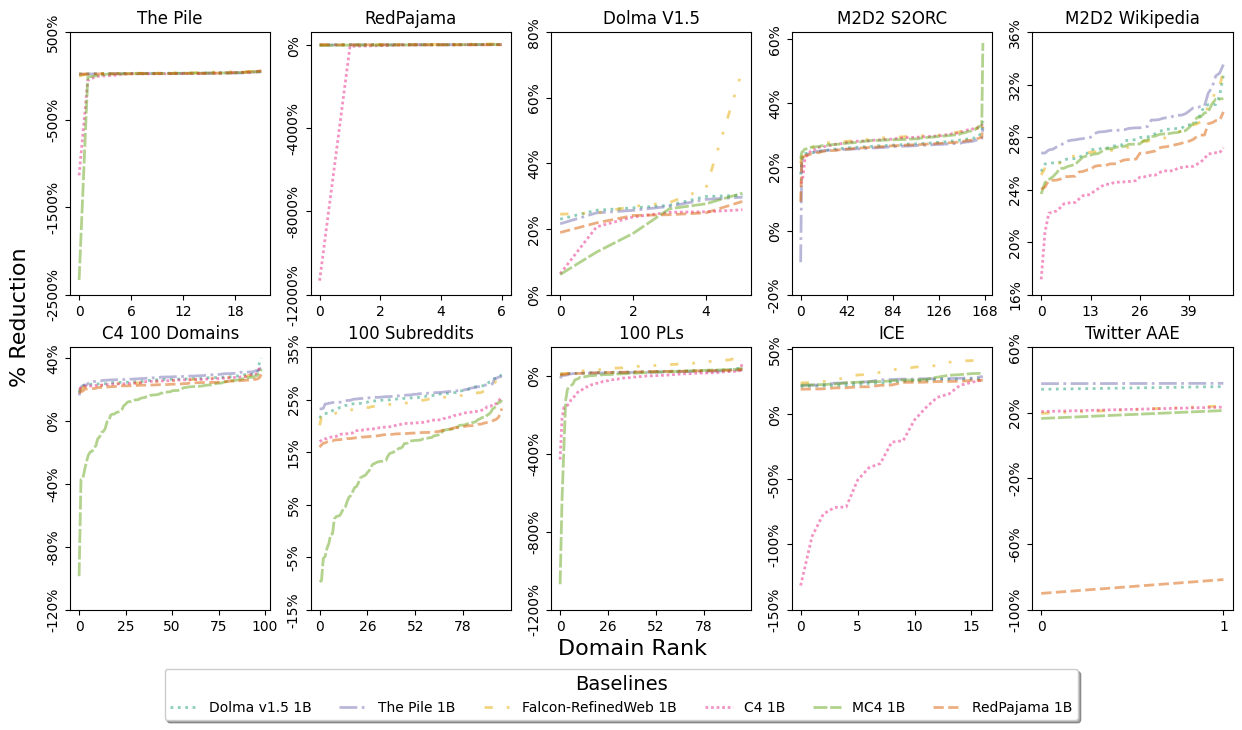

In [49]:
import matplotlib
cols = 5
models = {k:v for k,v in model_name_to_path.items() if k in trained_baseline_models}
# models = {k:v for k,v in model_name_to_path.items() if k in {'dolma-1b', 'pile-1b', 'rpj-1b'}}
# models = {k:v for k,v in model_name_to_path.items() if k in {'c4-1b', 'falcon-1b', 'mc4-1b'}}
tasks = ['ppl_'+domain for domain in domain_order if ('ppl_'+domain) in (domains_with_subdomains - {'ppl_manosphere_meta_sep'})]
fig, axs = plt.subplots(len(task_to_domains) // cols, cols, figsize=(15, 7.5), gridspec_kw={'hspace': 0.2, 'wspace': 0.2})
most_improved_domains = {}
least_improved_domains = {}
range_per_task = {}
prev_range_per_task = {}
for i, (model_name, model) in enumerate(models.items()):
    most_improved_domains[model_name] = {}
    least_improved_domains[model_name] = {}
    for j, task_name in enumerate(tasks):
        task_files = get_task_subdomains_results_files(results_files_clean, metric_name, task_name)
        model_path = os.path.join(RESULTS_DIR, model)
        all_subdomains = get_metric_for_all_subdomains(model_path, task_files, metric_name)
        max_all_subdomains = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()].reset_index(drop=True)
        min_all_subdomains = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].min()].reset_index(drop=True)
        domains = list(tasts_to_domains_clean[task_name])
        ratio_by_subdomain = 1 - max_all_subdomains[domains] / min_all_subdomains[domains]
        ratio_by_subdomain_series = ratio_by_subdomain.iloc[0].T
        negative_reduction = ratio_by_subdomain_series[ratio_by_subdomain_series < 0.0]

        most_improved = ratio_by_subdomain_series.sort_values(ascending=False)
        most_improved_domains[model_name][task_name] = {}
        most_improved_domains[model_name][task_name]['domain'] = most_improved.index[0]
        most_improved_domains[model_name][task_name]['reduction'] = f"{most_improved.iloc[0]:.2%}"

        least_improved_domains[model_name][task_name] = {}
        least_improved_domains[model_name][task_name]['domain'] = most_improved.index[-1]
        least_improved_domains[model_name][task_name]['reduction'] = f"{most_improved.iloc[-1]:.2%}"
        
        if len(negative_reduction):
            print(model_name)
            print(task_name)
            print(negative_reduction)
        ratio_by_subdomain = ratio_by_subdomain.values.flatten()
        ratio_by_subdomain.sort()
        y_axis = ratio_by_subdomain
        previous_range = range_per_task.get(task_name, (1e30, -1e30))
        if task_name not in prev_range_per_task:
            prev_range_per_task[task_name] = {}
        if min(y_axis) < previous_range[0]:
            prev_range_per_task[task_name]['min'] = previous_range[0]
        if max(y_axis) > previous_range[1]:
            prev_range_per_task[task_name]['max'] = previous_range[1]
        range_per_task[task_name] = (min(min(y_axis), previous_range[0]), max(max(y_axis), previous_range[1]))
        x_axis = np.arange(len(ratio_by_subdomain))
        # axs[j//cols][j%cols].scatter(x_axis, y_axis, label=(name_to_display[model_name]),  s=20, alpha=0.5, marker=model_name_to_marker[model_name], color=model_name_to_color[model_name])
        axs[j//cols][j%cols].plot(x_axis, y_axis, label=(name_to_display[model_name]), alpha=0.5, color=model_name_to_color[model_name], linestyle=model_name_to_linestyle[model_name], linewidth=2)

        # if j // cols == len(axs) - 1:
        #     axs[j//cols][j%cols].set_xlabel("Domain Rank")
        # # axs[j//cols][j%cols].set_xlabel("Domain Rank")

        # if j % cols == 0:
        #     axs[j//cols][j%cols].set_ylabel("% Reduction Perplexity")
        # axs[j//cols][j%cols].set_ylabel("% Reduction " +name_to_display[metric_name])
        axs[j//cols][j%cols].set_title(name_to_display[task_name])
        # x ticks as integers
        axs[j//cols][j%cols].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(len(ratio_by_subdomain)//4 + 1))
        # y ticks as percentages
        axs[j//cols][j%cols].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0, decimals=0))
        # print(len(ratio_by_subdomain))
        # axs[j//cols][j%cols].set_xlim(0, len(ratio_by_subdomain))

for j in range(len(tasks)):
    pass
    # axs[j//cols][j%cols].set_yscale('symlog')
    # y_max = range_per_task[tasks[j]][1]
    # y_min = range_per_task[tasks[j]][0]
    # print(tasks[j])
    # print(y_max)
    # print(y_min)
    # if y_min < -5.0:
    #     print ("here")
    #     print(y_min)
    #     y_min = prev_range_per_task[tasks[j]]['min']
    #     print(y_min)
    # axs[j//cols][j%cols].set_ylim(y_min -0.05 , y_max  + 0.05)
    y_ticks = axs[j//cols][j%cols].get_yticks()[::2]
    axs[j//cols][j%cols].set_yticks(y_ticks)
    axs[j//cols][j%cols].set_yticklabels([f"{y:.0%}" for y in y_ticks], rotation='vertical', ha='right', va='center')
    

axs[-1][0].legend(loc='upper center', bbox_to_anchor=(2.75, -0.2),
        ncol=6, fancybox=True, shadow=True, title='Baselines', title_fontsize=14)

fig.text(0.5, 0.05, 'Domain Rank', ha='center', fontsize=16)
fig.text(0.085, 0.5, '% Reduction', va='center', rotation='vertical', fontsize=16)


# fig.savefig(os.path.join(FIGURE_DIR,'domains_by_reduction.pdf'), bbox_inches='tight', dpi=300)

In [50]:
def make_multi_index_df_from_dict(data_dict, subcolumn_names):
    # create a multi-index for the columns and rows
    columns = pd.MultiIndex.from_product([[name_to_display[k] for k in data_dict.keys()], subcolumn_names])
    rows = list(name_to_display[task] for task in data_dict[list(data_dict.keys())[0]])

    # create the dataframe
    df = pd.DataFrame(index=rows, columns=columns)

    # fill in the dataframe with the data
    for model, tasks in data_dict.items():
        for task, subcolumns in tasks.items():
            for subcolumn, value in subcolumns.items():
                df.loc[name_to_display[task], (name_to_display[model], subcolumn)] = value
    return df

most_improved_domains_df = make_multi_index_df_from_dict(most_improved_domains, ['domain', 'reduction']).T
columns = most_improved_domains_df.columns
most_improved_domains_df[columns[:len(columns)//2]].to_latex(os.path.join(TABLES_DIR, 'most_improved_domains_part1.tex'), escape=True)
most_improved_domains_df[columns[len(columns)//2:]].to_latex(os.path.join(TABLES_DIR, 'most_improved_domains_part2.tex'), escape=True)
most_improved_domains_df

The Pile  RedPajama     Dolma V1.5  \
Dolma v1.5 1B        domain             EuroParl  wikipedia          books   
                     reduction            49.54%     34.41%         30.23%   
The Pile 1B          domain     YoutubeSubtitles  wikipedia          books   
                     reduction            44.43%     32.26%         29.65%   
Falcon-RefinedWeb 1B domain        StackExchange     github  stack_uniform   
                     reduction            53.16%     70.24%         68.39%   
C4 1B                domain             EuroParl  wikipedia           wiki   
                     reduction            50.13%     32.21%         25.84%   
MC4 1B               domain             EuroParl      arxiv          books   
                     reduction            47.23%     38.40%         30.87%   
RedPajama 1B         domain           Ubuntu_IRC  wikipedia          books   
                     reduction            58.58%     27.13%         28.36%   

                               M2D2 S2ORC  \
Dolma v1.5 1B        domain        hep-ex   
                     reduction     34.24%   
The Pile 1B          domain        hep-ex   
                     reduction     32.10%   
Falcon-RefinedWeb 1B domain        hep-ex   
                     reduction     32.88%   
C4 1B                domain        hep-ex   
                     reduction     33.41%   
MC4 1B               domain       stat.ME   
                     reduction     58.78%   
RedPajama 1B         domain        hep-ex   
                     reduction     32.66%   

                                                               M2D2 Wikipedia  \
Dolma v1.5 1B        domain     Natural_and_physical_sciences__Earth_sciences   
                     reduction                                         32.73%   
The Pile 1B          domain     Natural_and_physical_sciences__Earth_sciences   
                     reduction                                         33.52%   
Falcon-RefinedWeb 1B domain     Natural_and_physical_sciences__Earth_sciences   
                     reduction                                         33.05%   
C4 1B                domain                Religion_and_belief_systems__Allah   
                     reduction                                         27.17%   
MC4 1B               domain     Natural_and_physical_sciences__Earth_sciences   
                     reduction                                         30.93%   
RedPajama 1B         domain     Natural_and_physical_sciences__Earth_sciences   
                     reduction                                         29.91%   

                                                    C4 100 Domains  \
Dolma v1.5 1B        domain     59_app-wiringdiagram.herokuapp.com   
                     reduction                              40.34%   
The Pile 1B          domain                     39_www.booking.com   
                     reduction                              33.81%   
Falcon-RefinedWeb 1B domain                          58_medium.com   
                     reduction                              31.84%   
C4 1B                domain     59_app-wiringdiagram.herokuapp.com   
                     reduction                              34.84%   
MC4 1B               domain            97_archives.lib.state.ma.us   
                     reduction                              33.12%   
RedPajama 1B         domain     59_app-wiringdiagram.herokuapp.com   
                     reduction                              29.77%   

                                    100 Subreddits        100 PLs  \
Dolma v1.5 1B        domain            80_buildapc  83_dockerfile   
                     reduction              29.63%         39.64%   
The Pile 1B          domain              52_asoiaf  83_dockerfile   
                     reduction              29.42%         31.39%   
Falcon-RefinedWeb 1B domain                 42_wow      98_cython   
                     reduction              29.18%         9

In [51]:
least_improved_domains_df = make_multi_index_df_from_dict(least_improved_domains, ['domain', 'reduction']).T
columns = least_improved_domains_df.columns
least_improved_domains_df[columns[:len(columns)//2]].to_latex(os.path.join(TABLES_DIR, 'least_improved_domains_part1.tex'), escape=True)
least_improved_domains_df[columns[len(columns)//2:]].to_latex(os.path.join(TABLES_DIR, 'least_improved_domains_part2.tex'), escape=True)
least_improved_domains_df

The Pile   RedPajama      Dolma V1.5  \
Dolma v1.5 1B        domain      OpenSubtitles      github   stack_uniform   
                     reduction          20.85%      20.75%          22.97%   
The Pile 1B          domain     DM_Mathematics      github   stack_uniform   
                     reduction           9.01%      18.19%          21.54%   
Falcon-RefinedWeb 1B domain         Ubuntu_IRC          c4  reddit_uniform   
                     reduction          -3.90%      24.77%          24.48%   
C4 1B                domain              ArXiv       arxiv   stack_uniform   
                     reduction       -1138.53%  -11334.29%           6.29%   
MC4 1B               domain         Ubuntu_IRC      github    common-crawl   
                     reduction       -2334.31%      -9.86%           6.09%   
RedPajama 1B         domain     DM_Mathematics       arxiv  reddit_uniform   
                     reduction          20.60%      19.25%          18.90%   

                               M2D2 S2ORC                     M2D2 Wikipedia  \
Dolma v1.5 1B        domain       stat.ME                   General_referece   
                     reduction     17.57%                             25.37%   
The Pile 1B          domain       stat.ME              Mathematics_and_logic   
                     reduction     -9.88%                             26.78%   
Falcon-RefinedWeb 1B domain       stat.ME                   General_referece   
                     reduction     21.06%                             25.11%   
C4 1B                domain       math.GM                    Human_activites   
                     reduction     14.69%                             17.15%   
MC4 1B               domain      q-bio.QM  Culture_and_the_arts__Visual_arts   
                     reduction     22.50%                             23.66%   
RedPajama 1B         domain       stat.ME                   General_referece   
                     reduction      9.05%                             24.03%   

                                             C4 100 Domains    100 Subreddits  \
Dolma v1.5 1B        domain     82_mail-archives.apache.org     66_depression   
                     reduction                       18.57%            21.42%   
The Pile 1B          domain     82_mail-archives.apache.org   77_stopdrinking   
                     reduction                       16.46%            23.21%   
Falcon-RefinedWeb 1B domain         70_www.insiderpages.com     66_depression   
                     reduction                       19.78%            20.08%   
C4 1B                domain              38_www.youtube.com     66_depression   
                     reduction                       20.43%            16.98%   
MC4 1B               domain                  94_www.nme.com  91_dating_advice   
                     reduction                      -98.76%            -9.73%   
RedPajama 1B         domain     82_mail-archives.apache.org     66_depression   
                     reduction                       17.77%            15.93%   

                                         100 PLs              ICE Twitter AAE  
Dolma v1.5 1B        domain             74_cmake     CANADA_S_ALL       white  
                     reduction             9.74%           21.46%      34.22%  
The Pile 1B          domain            45_pascal     CANADA_S_ALL          AA  
                     reduction           -11.43%           22.48%      37.66%  
Falcon-RefinedWeb 1B domain               80_max    IRELAND_S_ALL       white  
                     reduction             6.43%           24.26%      19.55%  
C4 1B                domain               63_hcl  HONG_KONG_S_ALL       white  
                     reduction          -429.52%         -131.56%      20.65%  
MC4 1B               domain               80_max    JAMAICA_S_ALL          AA  
                     reduction         -1070.17%           22.44%      16.44%  
RedPajama 1B         domain     17_unity3d-asset

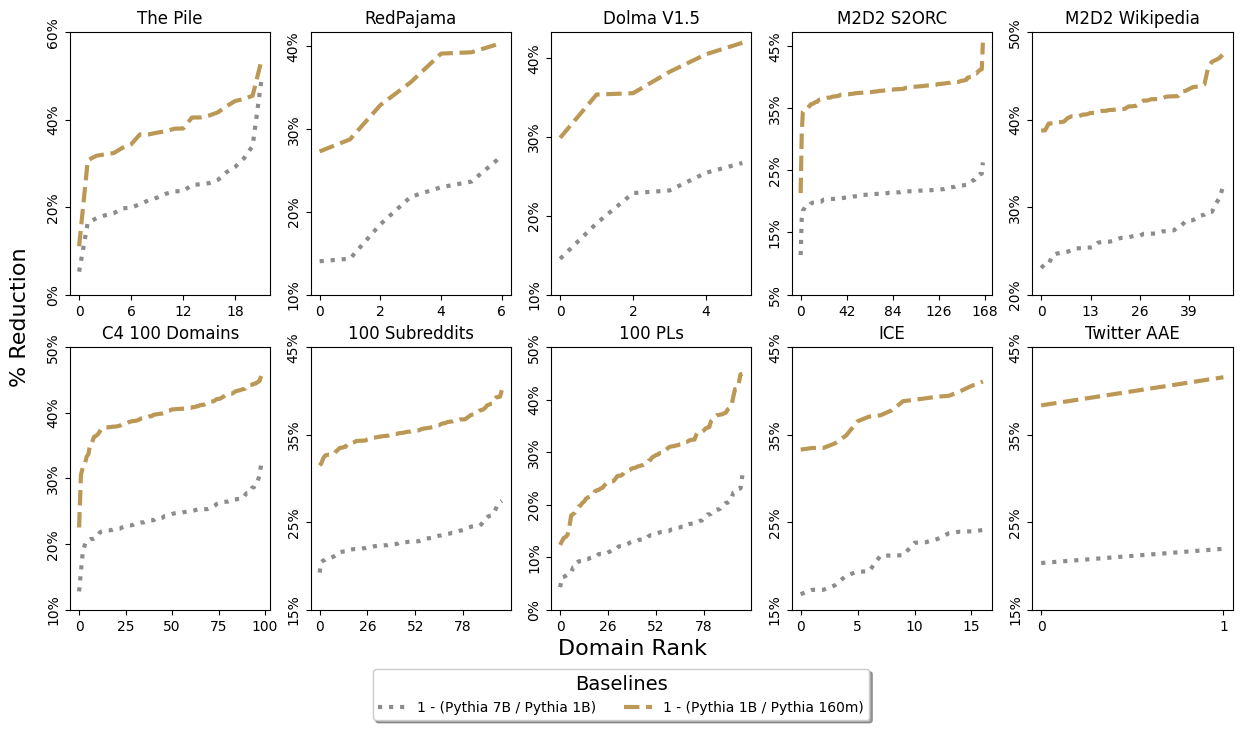

In [59]:
# comparing improvements over model sizes
import matplotlib
cols = 5
tasks = ['ppl_'+domain for domain in domain_order if ('ppl_'+domain) in (domains_with_subdomains - {'ppl_manosphere_meta_sep'})]
fig, axs = plt.subplots(len(task_to_domains) // cols, cols, figsize=(15, 7.5), gridspec_kw={'hspace': 0.2, 'wspace': 0.2})
most_improved_domains = {}
least_improved_domains = {}
for pair_idx, model_pair in enumerate([('pythia-6.9b', 'pythia-1b'), ('pythia-1b', 'pythia-160m')]):
    most_improved_domains[f"1-{name_to_display[model_pair[0]]}/{name_to_display[model_pair[1]]}"] = {}
    least_improved_domains[f"1-{name_to_display[model_pair[0]]}/{name_to_display[model_pair[1]]}"] = {}
    for j, task_name in enumerate(tasks):
        max_data = {}
        for i, model_name in enumerate(model_pair):
            model = model_name_to_path[model_name]
            task_files = get_task_subdomains_results_files(results_files_clean, metric_name, task_name)
            model_path = os.path.join(RESULTS_DIR, model)
            all_subdomains = get_metric_for_all_subdomains(model_path, task_files, metric_name)
            max_data[model_name] = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()].reset_index(drop=True)
        domains = list(tasts_to_domains_clean[task_name])
        max_all_subdomains = max_data[model_pair[0]]
        min_all_subdomains = max_data[model_pair[1]]
        ratio_by_subdomain = 1 - max_all_subdomains[domains] / min_all_subdomains[domains]
        ratio_by_subdomain_series = ratio_by_subdomain.iloc[0].T
        negative_reduction = ratio_by_subdomain_series[ratio_by_subdomain_series < 0.0]

        most_improved = ratio_by_subdomain_series.sort_values(ascending=False)
        most_improved_domains[f"1-{name_to_display[model_pair[0]]}/{name_to_display[model_pair[1]]}"][task_name] = {}
        most_improved_domains[f"1-{name_to_display[model_pair[0]]}/{name_to_display[model_pair[1]]}"][task_name]['domain'] = most_improved.index[0]
        most_improved_domains[f"1-{name_to_display[model_pair[0]]}/{name_to_display[model_pair[1]]}"][task_name]['reduction'] = f"{most_improved.iloc[0]:.2%}"

        least_improved_domains[f"1-{name_to_display[model_pair[0]]}/{name_to_display[model_pair[1]]}"][task_name] = {}
        least_improved_domains[f"1-{name_to_display[model_pair[0]]}/{name_to_display[model_pair[1]]}"][task_name]['domain'] = most_improved.index[-1]
        least_improved_domains[f"1-{name_to_display[model_pair[0]]}/{name_to_display[model_pair[1]]}"][task_name]['reduction'] = f"{most_improved.iloc[-1]:.2%}"
        
        if len(negative_reduction):
            print(task_name)
            print(negative_reduction)
        ratio_by_subdomain = ratio_by_subdomain.values.flatten()
        ratio_by_subdomain.sort()
        y_axis = ratio_by_subdomain
        x_axis = np.arange(len(ratio_by_subdomain))
        ratio_name = f"1-{name_to_display[model_pair[0]]}/{name_to_display[model_pair[1]]}"
        # axs[j//cols][j%cols].scatter(x_axis, y_axis, label=name_to_display[ratio_name], s=20, alpha=0.75, marker="x" if pair_idx == 0 else "o")
        axs[j//cols][j%cols].plot(x_axis, y_axis, label=name_to_display[ratio_name], alpha=0.75, linestyle=model_name_to_linestyle[ratio_name], linewidth=3, color=model_name_to_color[ratio_name])

        # if j // cols == len(axs) - 1:
        #     axs[j//cols][j%cols].set_xlabel("Domain Rank")
        # # axs[j//cols][j%cols].set_xlabel("Domain Rank")
        # if j % cols == 0:
        #     axs[j//cols][j%cols].set_ylabel("% Reduction Perplexity")
        # axs[j//cols][j%cols].set_ylabel("% Reduction " +name_to_display[metric_name])
        axs[j//cols][j%cols].set_title(name_to_display[task_name])
        # x ticks as integers
        axs[j//cols][j%cols].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(len(ratio_by_subdomain)//4 + 1))
        # y ticks as percentages
        axs[j//cols][j%cols].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
        # print(len(ratio_by_subdomain))
        # axs[j//cols][j%cols].set_xlim(0, len(ratio_by_subdomain))

for j in range(len(tasks)):
    y_ticks = axs[j//cols][j%cols].get_yticks()[::2]
    axs[j//cols][j%cols].set_yticks(y_ticks)
    axs[j//cols][j%cols].set_yticklabels([f"{y:.0%}" for y in y_ticks], rotation='vertical', ha='right', va='center')
axs[-1][0].legend(loc='upper center', bbox_to_anchor=(2.75, -0.2),
        ncol=2, fancybox=True, shadow=True, title='Baselines', title_fontsize=14)

fig.text(0.5, 0.05, 'Domain Rank', ha='center', fontsize=16)
fig.text(0.085, 0.5, '% Reduction', va='center', rotation='vertical', fontsize=16)


fig.savefig(os.path.join(FIGURE_DIR,'domains_by_reduction_model_size.pdf'), bbox_inches='tight', dpi=300)

In [54]:
most_improved_domains_df = make_multi_index_df_from_dict(most_improved_domains, ['domain', 'reduction']).T
columns = most_improved_domains_df.columns
most_improved_domains_df[columns[:len(columns)//2]].to_latex(os.path.join(TABLES_DIR, 'most_improved_domains_model_size_part1.tex'), escape=True)
most_improved_domains_df[columns[len(columns)//2:]].to_latex(os.path.join(TABLES_DIR, 'most_improved_domains_model_size_part2.tex'), escape=True)
most_improved_domains_df

The Pile  RedPajama  \
1 - (Pythia 7B / Pythia 1B)   domain        OpenSubtitles  wikipedia   
                              reduction            48.87%     26.73%   
1 - (Pythia 1B / Pythia 160m) domain     YoutubeSubtitles  wikipedia   
                              reduction            53.39%     40.39%   

                                        Dolma V1.5 M2D2 S2ORC  \
1 - (Pythia 7B / Pythia 1B)   domain         books     hep-ex   
                              reduction     26.69%     26.26%   
1 - (Pythia 1B / Pythia 160m) domain          wiki     hep-ex   
                              reduction     41.92%     45.54%   

                                                                        M2D2 Wikipedia  \
1 - (Pythia 7B / Pythia 1B)   domain     Natural_and_physical_sciences__Earth_sciences   
                              reduction                                         32.45%   
1 - (Pythia 1B / Pythia 160m) domain     Natural_and_physical_sciences__Earth_sciences   
                              reduction                                         47.51%   

                                                      C4 100 Domains  \
1 - (Pythia 7B / Pythia 1B)   domain     97_archives.lib.state.ma.us   
                              reduction                       32.23%   
1 - (Pythia 1B / Pythia 160m) domain                 76_deadline.com   
                              reduction                       45.66%   

                                        100 Subreddits     100 PLs  \
1 - (Pythia 7B / Pythia 1B)   domain            42_wow      35_ini   
                              reduction         27.41%      25.57%   
1 - (Pythia 1B / Pythia 160m) domain       80_buildapc  37_haskell   
                              reduction         40.06%      44.91%   

                                                       ICE Twitter AAE  
1 - (Pythia 7B / Pythia 1B)   domain     PHILIPPINES_W_ALL          AA  
                              reduction             24.08%      21.94%  
1 - (Pythia 1B / Pythia 160m) domain         IRELAND_W_ALL       white  
                              reduction             41.05%      41.54%

In [53]:
least_improved_domains_df = make_multi_index_df_from_dict(least_improved_domains, ['domain', 'reduction']).T
columns = least_improved_domains_df.columns
least_improved_domains_df[columns[:len(columns)//2]].to_latex(os.path.join(TABLES_DIR, 'least_improved_domains_model_size_part1.tex'), escape=True)
least_improved_domains_df[columns[len(columns)//2:]].to_latex(os.path.join(TABLES_DIR, 'least_improved_domains_model_size_part2.tex'), escape=True)
least_improved_domains_df

The Pile RedPajama  \
1 - (Pythia 7B / Pythia 1B)   domain     DM_Mathematics    github   
                              reduction           5.22%    14.02%   
1 - (Pythia 1B / Pythia 160m) domain     DM_Mathematics    github   
                              reduction          11.02%    27.28%   

                                            Dolma V1.5 M2D2 S2ORC  \
1 - (Pythia 7B / Pythia 1B)   domain     stack_uniform    stat.ME   
                              reduction         14.53%     11.35%   
1 - (Pythia 1B / Pythia 160m) domain     stack_uniform    stat.ME   
                              reduction         29.87%     21.32%   

                                                                       M2D2 Wikipedia  \
1 - (Pythia 7B / Pythia 1B)   domain                    Health_and_fitness__Nutrition   
                              reduction                                        23.02%   
1 - (Pythia 1B / Pythia 160m) domain     Mathematics_and_logic__Fields_of_mathematics   
                              reduction                                        38.75%   

                                                      C4 100 Domains  \
1 - (Pythia 7B / Pythia 1B)   domain     82_mail-archives.apache.org   
                              reduction                       12.76%   
1 - (Pythia 1B / Pythia 160m) domain     82_mail-archives.apache.org   
                              reduction                       22.50%   

                                        100 Subreddits           100 PLs  \
1 - (Pythia 7B / Pythia 1B)   domain     66_depression  17_unity3d-asset   
                              reduction         19.22%             4.25%   
1 - (Pythia 1B / Pythia 160m) domain     66_depression            50_edn   
                              reduction         31.47%            12.32%   

                                                   ICE Twitter AAE  
1 - (Pythia 7B / Pythia 1B)   domain     JAMAICA_S_ALL       white  
                              reduction         16.75%      20.31%  
1 - (Pythia 1B / Pythia 160m) domain      CANADA_S_ALL          AA  
                              reduction         33.27%      38.33%

## Disparities datasets

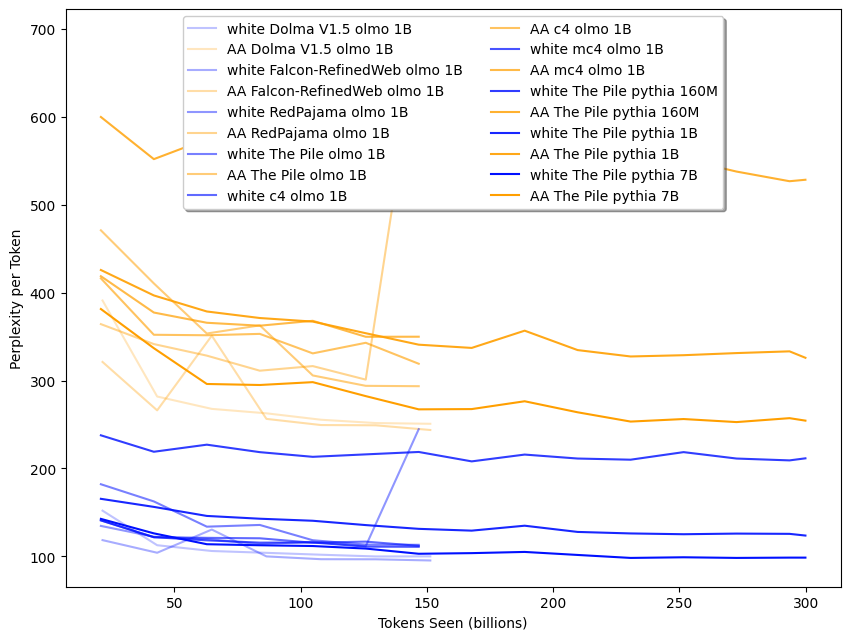

In [35]:
# show curves for each model (different color shades) over each domain (different hue) in a disparities task
# start with twitterAAE
models_all_domains = []
for i, (model_name, model) in enumerate(model_name_to_path.items()):
    model_path = os.path.join(RESULTS_DIR, model)
    models_all_domains.append(get_metric_for_all_subdomains(model_path, get_task_subdomains_results_files(results_files_clean, metric_name, 'ppl_twitterAAE_HELM_fixed'), metric_name))
models_all_domains = pd.concat(models_all_domains)

from matplotlib import colors
# domain_2_hue = {'white': 0.21303795923651603, 'AA': 0.8455261803248945}
domain_2_hue = {'white': colors.rgb_to_hsv(colors.to_rgb('blue'))[0], 'AA': colors.rgb_to_hsv(colors.to_rgb('orange'))[0]}
shades = iter(np.linspace(0.25, 1, len(model_name_to_path)))
fig, axs = plt.subplots(1, 1, figsize=(10, 7.5))
for (model, model_size, training_dataset), model_df in models_all_domains.groupby(['model', 'model_size', 'training_dataset']):
    x_axis = model_df['tokens_seen'] / 1000000000
    domains = list(set(model_df.columns) - set(shared_cols))
    # choose a random shade for this model
    shade = next(shades)
    for domain in domains:
        y_axis = model_df[domain]
        hue = domain_2_hue[domain]
        axs.plot(x_axis, y_axis, label=(domain+' '+training_dataset+' '+model+ f" {display_size(model_size)}"), color=plt.cm.hsv(hue, shade))
        # axs.plot(x_axis, y_axis, label=(domain+' '+training_dataset+' '+model+ f" {model_size/1000000000:.0f}B"))
axs.set_xlabel("Tokens Seen (billions)")
axs.set_ylabel(name_to_display[metric_name])
axs.legend(loc='upper center',
        ncol=2, fancybox=True, shadow=True)

# fig.savefig(os.path.join(FIGURE_DIR,'twitterAAE_curves.pdf'), bbox_inches='tight', dpi=300)

In [36]:
top_pmi_tokens_per_domain = {}
for domain in tasts_to_domains_clean['ppl_twitterAAE_HELM_fixed']:
    domain_token_freqs = get_token_freqs(get_token_counts(['ppl_twitterAAE_HELM_fixed_token_count_avg_logits.jsonl.gz'], subdomain = 'twitterAAE_HELM_fixed__'+domain))
    domain_token_pmi = get_pmi(domain_token_freqs, all_token_freqs)

    # sort by highest to lowest pmi
    sorted_domain_token_pmi = sorted(domain_token_pmi.items(), key=lambda x: x[1], reverse=True)
    sorted_domain_token_pmi
    # unzip
    sorted_domain_token_pmi_tokens, sorted_domain_token_pmi_pmi = zip(*sorted_domain_token_pmi)

    top_pmi_tokens_per_domain[name_to_display[domain]]=sorted_domain_token_pmi_tokens[:25]

# make df
top_pmi_tokens_per_domain_df = pd.DataFrame(top_pmi_tokens_per_domain)
# top_pmi_tokens_per_domain_df.to_latex(os.path.join(TABLES_DIR, 'top_pmi_tokens_per_domain_twitterAAE.tex'), escape=True)
top_pmi_tokens_per_domain_df




counting tokens in ppl_twitterAAE_HELM_fixed_token_count_avg_logits.jsonl.gz: 100%|██████████| 234017/234017 [00:00<00:00, 1930387.69it/s]
counting tokens in ppl_twitterAAE_HELM_fixed_token_count_avg_logits.jsonl.gz: 100%|██████████| 234017/234017 [00:00<00:00, 1939845.29it/s]


,White,AA
0,PLL,gether
1,Austin,jus
2,nyder,atever
3,kay,yo
4,natal,;&
5,ellees,fb
6,insi,nig
7,becca,
8,ゃ,ain
9,ielle,BGC


counting tokens in ppl_twitterAAE_HELM_fixed_token_count_avg_logits.jsonl.gz: 100%|██████████| 234017/234017 [00:00<00:00, 1940777.35it/s]
counting tokens in ppl_twitterAAE_HELM_fixed_token_count_avg_logits.jsonl.gz: 100%|██████████| 234017/234017 [00:00<00:00, 1928063.25it/s]


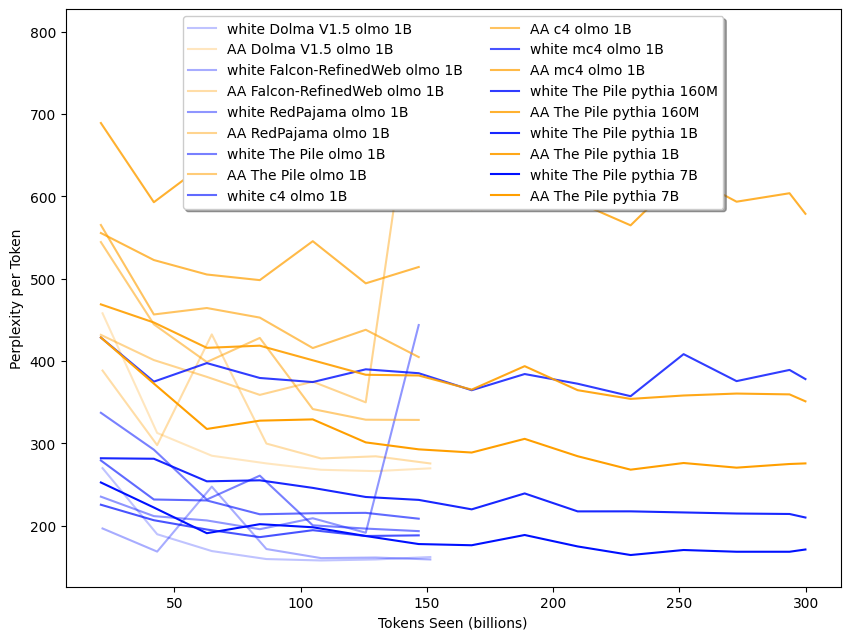

In [37]:
models_all_domains = []
for task_name in tasts_to_domains_clean['ppl_twitterAAE_HELM_fixed']:
    domain_token_freqs = get_token_freqs(get_token_counts(['ppl_twitterAAE_HELM_fixed_token_count_avg_logits.jsonl.gz'], subdomain = 'twitterAAE_HELM_fixed__'+task_name))
    domain_token_pmi = get_pmi(domain_token_freqs, all_token_freqs)

    # sort by highest to lowest pmi
    sorted_domain_token_pmi = sorted(domain_token_pmi.items(), key=lambda x: x[1], reverse=False)
    sorted_domain_token_pmi
    # unzip
    sorted_domain_token_pmi_tokens, sorted_domain_token_pmi_pmi = zip(*sorted_domain_token_pmi)
    model_all_tasks = []
    for i, (model_name, model) in enumerate(model_name_to_path.items()):
        model_path = os.path.join(RESULTS_DIR, model)
        model_all_tasks.append(get_metric_for_all_subdomains_from_vocab(model_path, ['ppl_twitterAAE_HELM_fixed'], metric_name, sorted_domain_token_pmi_tokens[-len(sorted_domain_token_pmi_tokens)//8:], task_granularity=False))
    present_shared_cols = [col for col in shared_cols if all([col in df.columns for df in model_all_tasks])]
    model_all_tasks = pd.concat(model_all_tasks)
    columns_to_drop=tasts_to_domains_clean['ppl_twitterAAE_HELM_fixed'] - set([task_name])
    model_all_tasks = model_all_tasks.drop(columns=columns_to_drop)
    models_all_domains.append(model_all_tasks)
models_all_domains = reduce(lambda left,right: pd.merge(left,right,on=list(present_shared_cols), how='outer'), models_all_domains)
models_all_domains

from matplotlib import colors
# domain_2_hue = {'white': 0.21303795923651603, 'AA': 0.8455261803248945}
domain_2_hue = {'white': colors.rgb_to_hsv(colors.to_rgb('blue'))[0], 'AA': colors.rgb_to_hsv(colors.to_rgb('orange'))[0]}
shades = iter(np.linspace(0.25, 1, len(model_name_to_path)))
fig, axs = plt.subplots(1, 1, figsize=(10, 7.5))
for (model, model_size, training_dataset), model_df in models_all_domains.groupby(['model', 'model_size', 'training_dataset']):
    x_axis = model_df['tokens_seen'] / 1000000000
    domains = list(set(model_df.columns) - set(shared_cols))
    # choose a random shade for this model
    shade = next(shades)
    for domain in domains:
        y_axis = model_df[domain]
        hue = domain_2_hue[domain]
        axs.plot(x_axis, y_axis, label=(domain+' '+training_dataset+' '+model+ f" {display_size(model_size)}"), color=plt.cm.hsv(hue, shade))
        # axs.plot(x_axis, y_axis, label=(domain+' '+training_dataset+' '+model+ f" {model_size/1000000000:.0f}B"))
axs.set_xlabel("Tokens Seen (billions)")
axs.set_ylabel(name_to_display[metric_name])
axs.legend(loc='upper center',
        ncol=2, fancybox=True, shadow=True)

# fig.savefig(os.path.join(FIGURE_DIR,'pmi_twitterAAE_curves.pdf'), bbox_inches='tight', dpi=300)

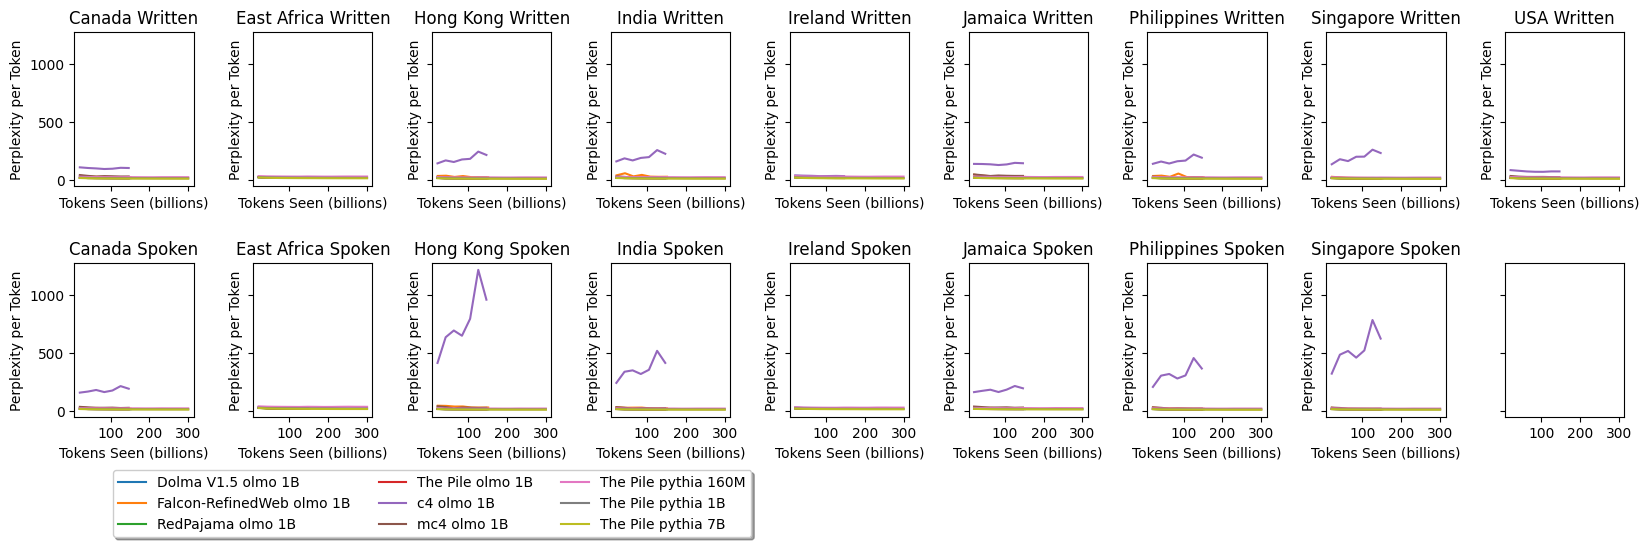

In [38]:
# start with ICE
models_all_domains = []
for i, (model_name, model) in enumerate(model_name_to_path.items()):
    model_path = os.path.join(RESULTS_DIR, model)
    models_all_domains.append(get_metric_for_all_subdomains(model_path, get_task_subdomains_results_files(results_files_clean, metric_name, 'ppl_ice_fixed'), metric_name))
models_all_domains = pd.concat(models_all_domains)

domains = list(set(models_all_domains.columns) - set(shared_cols))
domains_spoken = [domain for domain in domains if '_S_' in domain]
domains_spoken.sort()
domains_written = [domain for domain in domains if '_W_' in domain]
domains_written.sort()
domains = domains_written + domains_spoken
cols = 9
fig, axs = plt.subplots(len(domains) // cols + 1, cols, figsize=(20, 5), gridspec_kw={'hspace': 0.5, 'wspace': 0.5}, sharex=True, sharey=True)
for (model, model_size, training_dataset), model_df in models_all_domains.groupby(['model', 'model_size', 'training_dataset']):
    x_axis = model_df['tokens_seen'] / 1000000000
    for i, domain in enumerate(domains):
        y_axis = model_df[domain]
        axs[i//cols][i%cols].plot(x_axis, y_axis, label=(training_dataset+' '+model+ f" {display_size(model_size)}"))
        axs[i//cols][i%cols].set_xlabel("Tokens Seen (billions)")
        axs[i//cols][i%cols].set_ylabel(name_to_display[metric_name])
        axs[i//cols][i%cols].set_title(name_to_display[domain])
axs[-1][0].legend(loc='upper center', bbox_to_anchor=(3, -0.3),
        ncol=3, fancybox=True, shadow=True)


# fig.savefig(os.path.join(FIGURE_DIR,'ICE_curves.pdf'), bbox_inches='tight', dpi=300)

In [39]:
# top_pmi_tokens_per_domain = {}
# for domain in tasts_to_domains_clean['ppl_ice_fixed']:
#     domain_token_freqs = get_token_freqs(get_token_counts(['ppl_ice_fixed_token_count_avg_logits.jsonl.gz'], subdomain = 'ice_HELM__'+domain))
#     domain_token_pmi = get_pmi(domain_token_freqs, all_token_freqs)

#     # sort by highest to lowest pmi
#     sorted_domain_token_pmi = sorted(domain_token_pmi.items(), key=lambda x: x[1], reverse=True)
#     sorted_domain_token_pmi
#     # unzip
#     sorted_domain_token_pmi_tokens, sorted_domain_token_pmi_pmi = zip(*sorted_domain_token_pmi)

#     top_pmi_tokens_per_domain[name_to_display[domain]]=sorted_domain_token_pmi_tokens[:25]

# with open(os.path.join(TOKEN_COUNTS_DIR, "ice_top_pmi_tokens_per_domain.json"), 'w') as fout:
#     json.dump(top_pmi_tokens_per_domain, fout)
with open(os.path.join(TOKEN_COUNTS_DIR, "ice_top_pmi_tokens_per_domain.json"), 'r') as fin:
    top_pmi_tokens_per_domain = json.load(fin)

# make df
top_pmi_tokens_per_domain_df = pd.DataFrame(top_pmi_tokens_per_domain)
# top_pmi_tokens_per_domain_df.to_latex(os.path.join(TABLES_DIR, 'top_pmi_tokens_per_domain_ice.tex'), escape=True)
top_pmi_tokens_per_domain_df


,India Spoken,East Africa Spoken,Singapore Spoken,Ireland Written,Hong Kong Written,Canada Written,Philippines Written,Hong Kong Spoken,Singapore Written,USA Written,East Africa Written,Canada Spoken,Jamaica Written,India Written,Ireland Spoken,Philippines Spoken,Jamaica Spoken
0,ecause,yond,Petitioners,Ð,rsquo,,idopsis,unc,behavi,inical,hether,hmm,earthqu,Ibid,syll,polymers,
1,ammon,Excell,Indones,*>,HbA,ipeg,ernate,ll,clo,,sime,Mm,adoles,enthus,Aye,Atty,Jama
2,spermat,/>.,Ya,prest,HK,riched,opausal,hm,gesterone,ometimes,scious,swick,,pestic,hatic,empre,<-
3,behavi,maize,Defendants,DMSO,amyl,Qué,pes,Defendant,reef,,ederal,Sutton,Jamaica,krit,Tao,incorpor,Geoffrey
4,tablespoons,/>,dur,lace,mellitus,Canad,ORANDUM,Kong,apore,,appellants,atchewan,ometimes,progen,Belfast,Honor,",,"
5,",,",?>,Plaintiffs,Belfast,hk,nutrients,quo,Hong,Disorders,predicated,respondent,hh,progen,inition,Mm,pes,Jamaica
6,Kashmir,iban,Kok,mould,mmol,Hume,Philippine,huh,iddell,bersome,Appellant,Brunswick,Jama,hatic,Irish,Exhibit,)</
7,ammonium,oslov,counterclaim,sludge,GTT,,\n\n \n,defendant,Singapore,ligation,Juda,Bears,Carib,germination,Huh,Honorable,donkey
8,teaspoons,airo,ah,pollen,diox,travail,Ramos,Uh,459,obenz,BCG,Deg,\n\n,etch,Okay,andez,complainant
9,Punjab,amined,Respondents,Dear,hypergly,\n\n\n,Elli,Z,cloves,substantial,afore,Ya,,oxia,rendan,Lucia,Kingston


## fringe datasets


In [40]:
fringe_domains

{'ppl_4chan_meta_sep', 'ppl_gab', 'ppl_manosphere_meta_sep'}

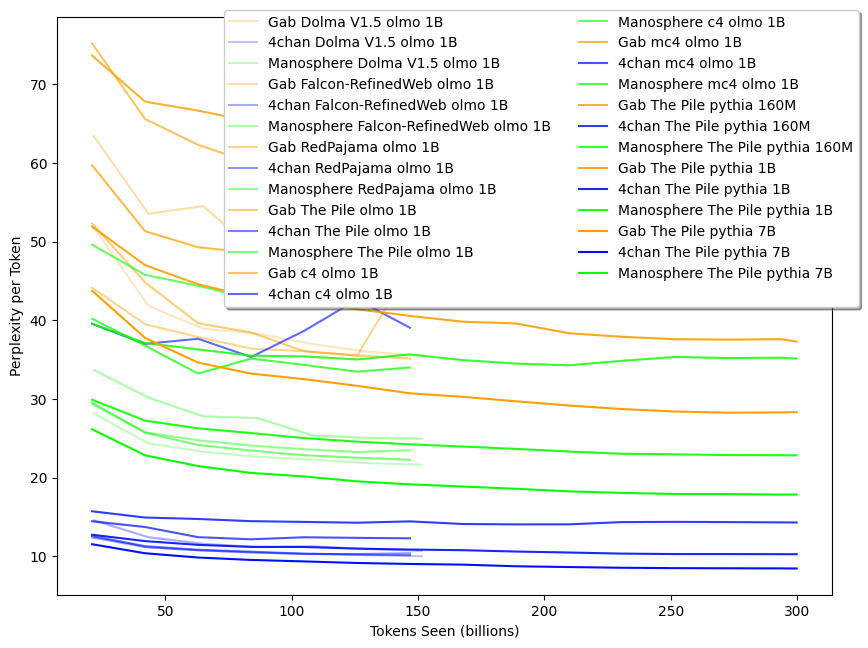

In [41]:

models_all_domains = []
for i, (model_name, model) in enumerate(model_name_to_path.items()):
    model_path = os.path.join(RESULTS_DIR, model)
    models_all_domains.append(get_metric_for_all_subdomains(model_path, [], metric_name, fringe_domains))
models_all_domains = pd.concat(models_all_domains)
models_all_domains

from matplotlib import colors
domain_2_hue = {
    'ppl_4chan_meta_sep':colors.rgb_to_hsv(colors.to_rgb('blue'))[0],
    'ppl_gab':colors.rgb_to_hsv(colors.to_rgb('orange'))[0],
    'ppl_manosphere_meta_sep':colors.rgb_to_hsv(colors.to_rgb('green'))[0]
}
shades = iter(np.linspace(0.25, 1, len(model_name_to_path)))
fig, axs = plt.subplots(1, 1, figsize=(10, 7.5))
for (model, model_size, training_dataset), model_df in models_all_domains.groupby(['model', 'model_size', 'training_dataset']):
    x_axis = model_df['tokens_seen'] / 1000000000
    domains = list(set(model_df.columns) - set(shared_cols))
    # choose a random shade for this model
    shade = next(shades)
    for domain in domains:
        y_axis = model_df[domain]
        hue = domain_2_hue[domain]
        axs.plot(x_axis, y_axis, label=(name_to_display[domain]+' '+training_dataset+' '+model+ f" {display_size(model_size)}"), color=plt.cm.hsv(hue, shade))
        # axs.plot(x_axis, y_axis, label=(domain+' '+training_dataset+' '+model+ f" {model_size/1000000000:.0f}B"))
axs.set_xlabel("Tokens Seen (billions)")
axs.set_ylabel(name_to_display[metric_name])
axs.legend(loc='upper center', bbox_to_anchor=(.625, 1.025),
        ncol=2, fancybox=True, shadow=True)

# fig.savefig(os.path.join(FIGURE_DIR,'fringe_curves.pdf'), bbox_inches='tight', dpi=300)

In [42]:
top_pmi_tokens_per_domain = {}
for domain in fringe_domains:
    domain_token_freqs = get_token_freqs(get_token_counts([domain+'_token_count_avg_logits.jsonl.gz']))
    domain_token_pmi = get_pmi(domain_token_freqs, all_token_freqs)

    # sort by highest to lowest pmi
    sorted_domain_token_pmi = sorted(domain_token_pmi.items(), key=lambda x: x[1], reverse=True)
    sorted_domain_token_pmi
    # unzip
    sorted_domain_token_pmi_tokens, sorted_domain_token_pmi_pmi = zip(*sorted_domain_token_pmi)

    top_pmi_tokens_per_domain[name_to_display[domain]]=sorted_domain_token_pmi_tokens[:25]

# make df
top_pmi_tokens_per_domain_df = pd.DataFrame(top_pmi_tokens_per_domain)
# top_pmi_tokens_per_domain_df.to_latex(os.path.join(TABLES_DIR, 'top_pmi_tokens_per_domain_fringe.tex'), escape=True)
top_pmi_tokens_per_domain_df




counting tokens in ppl_gab_token_count_avg_logits.jsonl.gz: 100%|██████████| 216006/216006 [00:00<00:00, 1713802.49it/s]
counting tokens in ppl_4chan_meta_sep_token_count_avg_logits.jsonl.gz: 100%|██████████| 171171/171171 [00:00<00:00, 1697634.50it/s]
counting tokens in ppl_manosphere_meta_sep_token_count_avg_logits.jsonl.gz: 100%|██████████| 546931/546931 [00:00<00:00, 1812861.45it/s]


,Gab,4chan,Manosphere
0,zitter,parison,BOOST
1,,icense,sÃ
2,*-*,Anonymous,amss
3,pmb,Tue,ortunately
4,ssä,Fri,ella
5,frak,Thu,Wrote
6,ottom,Wed,leted
7,WARRANT,Sun,Click
8,Gab,Sat,HB
9,MAG,>>,_________________


In [43]:
get_metric_for_all_subdomains_from_vocab(model_path, ['ppl_manosphere_meta_sep'], 'ppl_token', sorted_domain_token_pmi_tokens, task_granularity=True)

,ppl_manosphere_meta_sep,training_dataset,model_size,model,training_steps,tokens_seen
0,26.141577,The Pile,6444163072,pythia,10000,20971520000
1,22.827385,The Pile,6444163072,pythia,20000,41943040000
2,21.460419,The Pile,6444163072,pythia,30000,62914560000
3,20.588593,The Pile,6444163072,pythia,40000,83886080000
4,20.141649,The Pile,6444163072,pythia,50000,104857600000
5,19.518745,The Pile,6444163072,pythia,60000,125829120000
6,19.136755,The Pile,6444163072,pythia,70000,146800640000
7,18.855800,The Pile,6444163072,pythia,80000,167772160000
8,18.569826,The Pile,6444163072,pythia,90000,188743680000
9,18.244831,The Pile,6444163072,pythia,100000,209715200000


In [44]:
# models_all_domains = []
# for task_name in fringe_domains:
#     domain_token_freqs = get_token_freqs(get_token_counts([task_name+'_token_count_avg_logits.jsonl.gz']))
#     domain_token_pmi = get_pmi(domain_token_freqs, all_token_freqs)

#     # sort by highest to lowest pmi
#     sorted_domain_token_pmi = sorted(domain_token_pmi.items(), key=lambda x: x[1], reverse=False)
#     sorted_domain_token_pmi
#     # unzip
#     sorted_domain_token_pmi_tokens, sorted_domain_token_pmi_pmi = zip(*sorted_domain_token_pmi)
#     model_all_tasks = []
#     for i, (model_name, model) in enumerate(model_name_to_path.items()):
#         model_path = os.path.join(RESULTS_DIR, model)
#         model_all_tasks.append(get_metric_for_all_subdomains_from_vocab(model_path, [task_name], metric_name, sorted_domain_token_pmi_tokens[-len(sorted_domain_token_pmi_tokens)//8:], task_granularity=True))
#     present_shared_cols = [col for col in shared_cols if all([col in df.columns for df in model_all_tasks])]
#     model_all_tasks = pd.concat(model_all_tasks)
#     models_all_domains.append(model_all_tasks)
# models_all_domains = reduce(lambda left,right: pd.merge(left,right,on=list(present_shared_cols), how='outer'), models_all_domains)
# models_all_domains

# from matplotlib import colors
# domain_2_hue = {
#     'ppl_4chan_meta_sep':colors.rgb_to_hsv(colors.to_rgb('blue'))[0],
#     'ppl_gab':colors.rgb_to_hsv(colors.to_rgb('orange'))[0],
#     'ppl_manosphere_meta_sep':colors.rgb_to_hsv(colors.to_rgb('green'))[0]
# }
# shades = iter(np.linspace(0.25, 1, len(model_name_to_path)))
# fig, axs = plt.subplots(1, 1, figsize=(10, 7.5))
# for (model, model_size, training_dataset), model_df in models_all_domains.groupby(['model', 'model_size', 'training_dataset']):
#     x_axis = model_df['tokens_seen'] / 1000000000
#     domains = list(set(model_df.columns) - set(shared_cols))
#     # choose a random shade for this model
#     shade = next(shades)
#     for domain in domains:
#         y_axis = model_df[domain]
#         hue = domain_2_hue[domain]
#         axs.plot(x_axis, y_axis, label=(name_to_display[domain]+' '+training_dataset+' '+model+ f" {display_size(model_size)}"), color=plt.cm.hsv(hue, shade))
#         # axs.plot(x_axis, y_axis, label=(domain+' '+training_dataset+' '+model+ f" {model_size/1000000000:.0f}B"))
# axs.set_xlabel("Tokens Seen (billions)")
# axs.set_ylabel(name_to_display[metric_name])
# axs.legend(loc='upper center', bbox_to_anchor=(.625, 1.025),
#         ncol=2, fancybox=True, shadow=True)

# fig.savefig(os.path.join(FIGURE_DIR,'pmi_fringe_curves.pdf'), bbox_inches='tight', dpi=300)

## Decontamination removal rates

In [45]:
decon_stats = [
    [name_to_macro['dolma-v1_5'], 0.00062],
    [name_to_macro['redpajama'], 1 - 900799243 / 901687943],
    [name_to_macro['pile'], 1 - 204809882 / 210607728],
    [name_to_macro['falcon-refinedweb'], 1- 912114192 / 918848690 ],
    [name_to_macro['c4_en'], 1 - 364121142 / 364156258 ],
    [name_to_macro['mc4'], 1 -  3928652800 / 3928733374],
]

decon_stats_df = pd.DataFrame(decon_stats, columns=['Dataset', 'Document Removal Rate'])
formaters = {'Document Removal Rate': lambda x: f'{x:.3%}'.replace('%', '\%')}
decon_stats_df.to_latex(os.path.join(TABLES_DIR, 'decon_removal.tex'), index=False, formatters=formaters)
decon_stats_df.style.format({'Document Removal Rate': "{:.3%}"})

,Dataset,Document Removal Rate
0,\dolma,0.062%
1,\redPajama,0.099%
2,\pile,2.753%
3,\falcon,0.733%
4,\cFour,0.010%
5,\mCFourEn,0.002%


## subsetting numbers

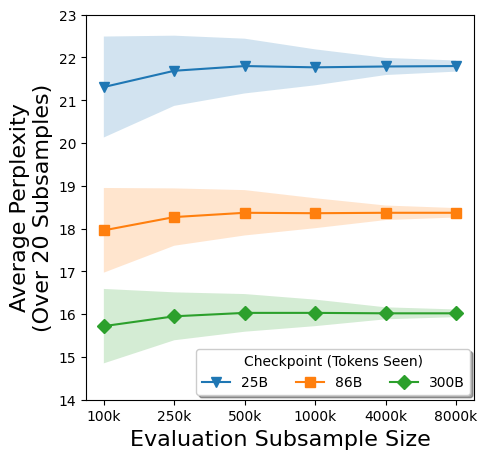

In [46]:
import pandas as pd
mean_df = pd.read_csv('/Users/ianm/projects/ppl-suite-website/subsample_mean.csv').rename(columns={'Unnamed: 0': 'checkpoint'}).set_index('checkpoint')
std_df = pd.read_csv('/Users/ianm/projects/ppl-suite-website/subsample_std.csv').rename(columns={'Unnamed: 0': 'checkpoint'}).set_index('checkpoint')



# line plot with error bars for each checkpoint
import matplotlib.pyplot as plt
import numpy as np

# mean_df = np.log(np.log(mean_df))
# std_df = np.log(np.log(std_df))
checkpoint_to_marker = {
    '4B': 'o',
    '25B': 'v',
    '86B': 's',
    '300B': 'D',
    # '5B': 'P',
    # '6B': 'X',
    # '7B': 'd',
    # '8B': 'p',
    # '9B': 'h',
    # '10B': '*',
}

fig, axs = plt.subplots(1, 1, figsize=(5, 5), sharey=True, sharex=True)
for i, (checkpoint, mean) in enumerate(mean_df.iterrows()):
    if checkpoint == '4B':
        continue
    std = std_df.loc[checkpoint]
    x_axis = mean_df.columns
    mean_high = mean + std
    mean_low = mean - std
    # mean_high = np.log(np.log(mean + std))
    # mean_low = np.log(np.log(mean - std))
    # mean = np.log(np.log(mean))
    axs.plot(x_axis, mean, label=checkpoint, marker=checkpoint_to_marker[checkpoint], markersize=7)
    axs.fill_between(x_axis, mean_high, mean_low, alpha=0.2)
axs.set_xlabel("Evaluation Subsample Size", fontsize=16)
axs.set_ylabel("Average Perplexity\n(Over 20 Subsamples)", fontsize=16)
y_ticks = axs.get_yticks()
axs.set_yticks(y_ticks)
# axs.set_yticklabels([f"{y:.0f}" for y in np.exp(np.exp(y_ticks))], rotation='vertical', ha='right', va='center')
# natural log scale
# axs.set_yscale('log')
axs.legend(loc='upper center', bbox_to_anchor=(.6375, .15),
        ncol=3, fancybox=True, shadow=True, title='Checkpoint (Tokens Seen)')

fig.savefig(os.path.join(FIGURE_DIR,'subsample_size.pdf'), bbox_inches='tight', dpi=300)


## MISC debug

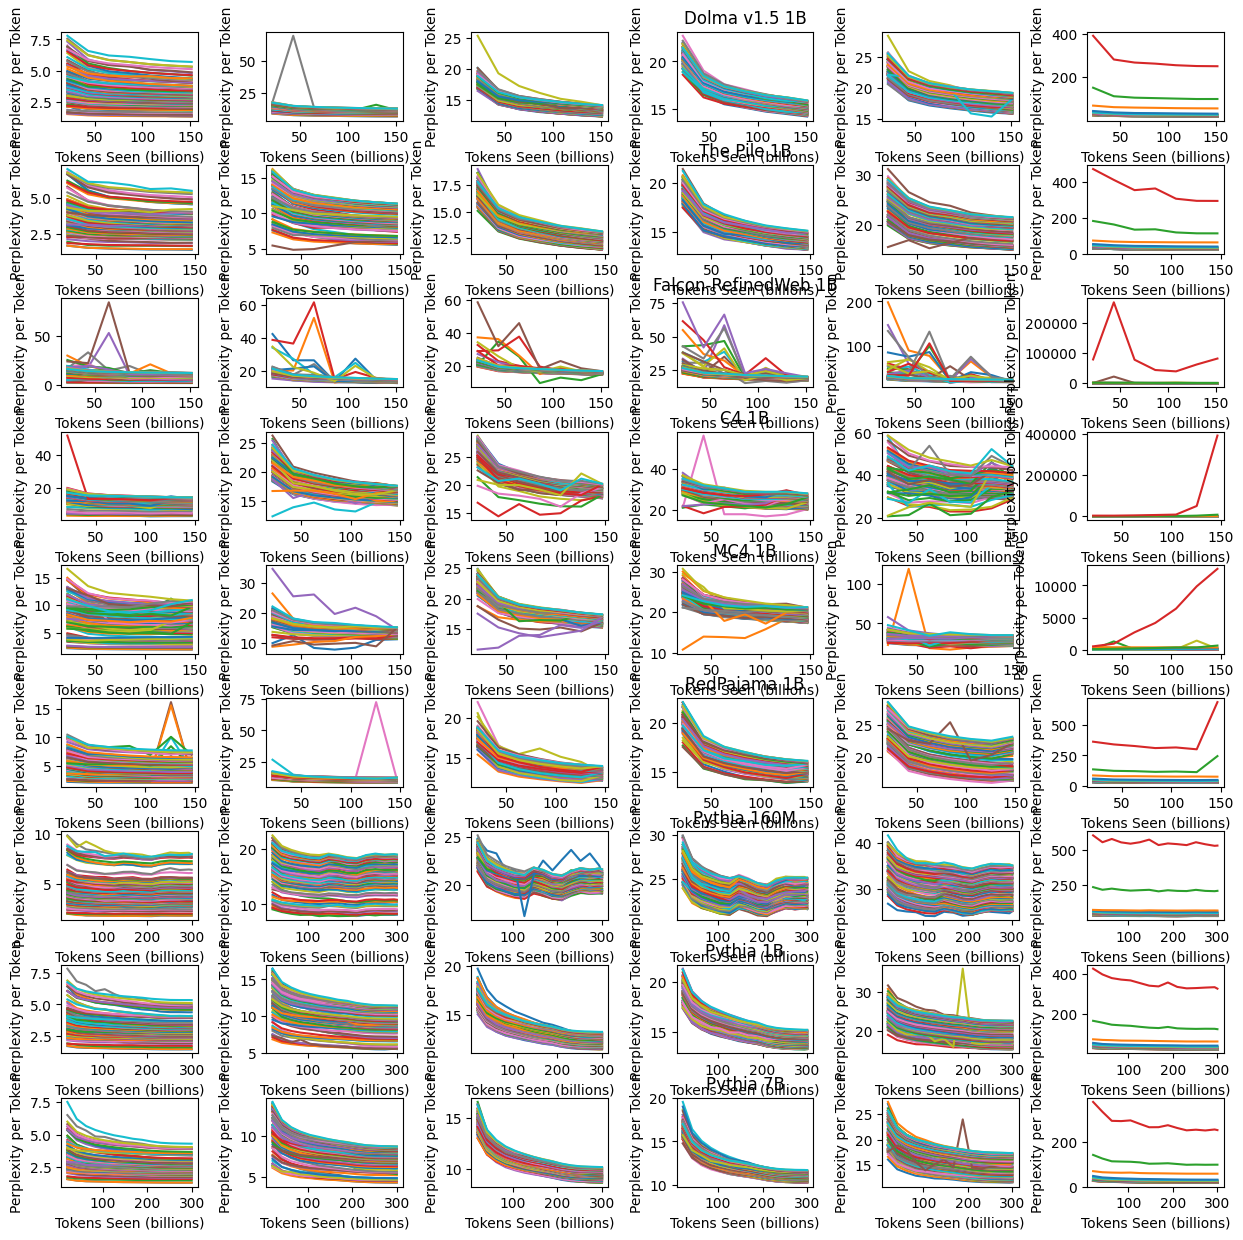

In [47]:
# one subplot per model, with lines for each subdomain

import matplotlib.pyplot as plt
import numpy as np

# one subplot for each model
fig, axs = plt.subplots(len(model_name_to_path), 6, figsize=(15, 15), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

# line chare for each model
for i, (model_name, model) in enumerate(model_name_to_path.items()):
    model_path = os.path.join(RESULTS_DIR, model)
    all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, metric_name, domains_without_subdomains_clean)
    max_tokens_seen_row = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()].reset_index(drop=True).drop(columns=shared_cols).T.rename(columns={0: 'metric'})
    domains_by_final_ppl = list(max_tokens_seen_row.sort_values(by='metric', axis=0).index)
    
    for j in range(6):
        for subdomain in domains_by_final_ppl[j*100:j*100+100]:
            x_axis = all_subdomains['tokens_seen'] / 1000000000
            y_axis = all_subdomains[subdomain]
            axs[i][j].plot(x_axis, y_axis, label=subdomain)
        axs[i][j].set_xlabel("Tokens Seen (billions)")
        axs[i][j].set_ylabel(name_to_display[metric_name])
    # axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, .95),
    #       ncol=3, fancybox=True, shadow=True)
    axs[i][3].set_title(name_to_display[model_name])
plt.show()

# fig.savefig(os.path.join(FIGURE_DIR,'curves_for_all_subdomains.pdf'), bbox_inches='tight', dpi=300)


In [48]:
# win rates
model_name_to_path_1b = {k: v for k, v in model_name_to_path.items() if '1b' in k and k != 'pythia-1b'}
rankings_table = make_ranking_table(get_win_rate_over_all_subdomains, metric_name, model_name_to_path_1b).drop(columns=['training_steps','split'])
rankings_table.rename(columns=name_to_display, inplace=True)
column_format = ('p{'+ str(1/ len(rankings_table.columns)*.5)+'\\textwidth}') * len(rankings_table.columns)
formaters = {name_to_display['model_size']: lambda x: display_size(x)}
rankings_table.to_latex(os.path.join(TABLES_DIR, 'final_checkpoints_1b_win_rates_per_tasks.tex'), index=False, float_format="%.2f", column_format=column_format, formatters=formaters)
rankings_table

,Training Dataset,Model Size,Model,Tokens Seen,C4 100 Domains,100 Subreddits,M2D2 S2ORC,The Pile,M2D2 Wikipedia,Dolma V1.5,Twitter AAE,ICE,RedPajama,100 PLs,All
0,Dolma V1.5,1177240704,olmo,151388160000,0.040404,1.0,0.000000,0.000000,0.000000,0.5,0.0,0.000000,0.000000,0.65,0.250602
1,The Pile,1177240704,olmo,146800640000,0.040404,0.0,0.988024,0.909091,0.306122,0.5,0.0,0.882353,0.571429,0.35,0.443373
2,Falcon-RefinedWeb,1177240704,olmo,151388160000,0.282828,0.0,0.000000,0.045455,0.000000,0.0,1.0,0.058824,0.000000,0.00,0.067470
3,c4,1177240704,olmo,146800640000,0.484848,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.142857,0.00,0.115663
4,mc4,1177240704,olmo,146800640000,0.000000,0.0,0.005988,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.002410
5,RedPajama,1177240704,olmo,146800640000,0.151515,0.0,0.005988,0.045455,0.693878,0.0,0.0,0.058824,0.285714,0.00,0.120482
